# iFood CRM data

This data is from iFood, a food delivery app in Brazil

The data consists of 2240 rows of customer details (income, number of children, education etc) for customers selected for a marketing campaign. There is also a variable ("Response") indicating wether or not the customer accepted the offer from the campaign. The github repo and project brief are linked below.

[GitHub repo](https://github.com/mauricebrown/)

[Project brief and data dictionary](https://github.com/nailson/ifood-data-business-analyst-test/blob/master/iFood%20Data%20Analyst%20Case.pdf)

This Notebook is split into **four** sections:

1. **Data import and cleansing**
    - Import data and remove missing values
    - Create aggregations of data so that models contain fewer variables
2. **Data exploration**
    - Grouping the data by several variables and using the dependent variable ("Repsonse") to check whether there is a meaningful difference between the groups    
3. **Modelling**
    - Creating a model to predict the customer response based on variables chosen from the exploration phase
    - Two models are created:
        1. A random forest classifier (**more accurate**)
        2. A logistic regression classifier (**more easily interpretable**)
4. **Frequency, recency, monetary value (FRM) analysis**

There are "stream of consciousness" notes throughout the notebook to give an indication of the thought behind specific actions (data groupings, chart creation etc).

In [1]:
from datetime import datetime, timedelta
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

# 1) import data and check for null values

In [5]:
data_file_url = 'https://raw.githubusercontent.com/nailson/ifood-data-business-analyst-test/master/ifood_df.csv'
df = pd.read_csv(data_file_url)
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [14]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [15]:
df.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [324]:
# convert "Dt_Customer" column to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# get minimum date
first_date = df['Dt_Customer'].min()

# add column for customer age in years (i.e. how long the customer has been with the company, NOT their actual age)
df['CustomerYears'] = df['Dt_Customer'].apply(lambda x: (x - first_date).days/365)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,3,11,1,0,1617,25,0,0.098630
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,3,11,0,2,27,6,0,1.605479
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,3,11,0,0,776,21,0,1.060274
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,3,11,0,1,53,8,0,1.534247
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,3,11,0,1,422,19,0,1.473973


In [426]:
# add a column for age
current_year = datetime.now().year

df['Age'] = current_year - df['Year_Birth']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,3,11,1,0,1617,25,0,0.098630,66
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,3,11,0,2,27,6,0,1.605479,69
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,3,11,0,0,776,21,0,1.060274,58
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,3,11,0,1,53,8,0,1.534247,39
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,3,11,0,1,422,19,0,1.473973,42


### 1a) since there's only 24 rows with na (circa 1% of the data) we'll drop those rows

In [30]:
df.dropna(inplace=True)

# check only 24 rows were dropped
df.shape

(2216, 33)

### 1b) aggregations

* create a column for "ChildrenTotal", which sums the "Kidhome" and "Teenhome" columns
* create a column for "MntTotal", which sums the "Mnt_" columns
* create a column for "NumPurchasesTotal", which sums the "Num_Purchases" columns
* create a column "AcceptedTotal", which sums the "AcceptedCmp_" columns

In [16]:
children_cols = [
    'Kidhome',
    'Teenhome'    
]

mnt_cols = [
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds'
]

num_purchases_cols = [
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases'
]
    
accepted_cols = [
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5'
]

In [29]:
df['ChildrenTotal'] = df[children_cols].sum(axis=1)
df['MntTotal'] = df[mnt_cols].sum(axis=1)
df['NumPurchasesTotal'] = df[num_purchases_cols].sum(axis=1)
df['AcceptedTotal'] = df[accepted_cols].sum(axis=1)

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,3,11,1,0,1617,25,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,3,11,0,2,27,6,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,3,11,0,0,776,21,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,3,11,0,1,53,8,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,3,11,0,1,422,19,0


### 1c) checking aggregations

#### let's see how correlated the Mnt_ columns are and how correlated the Num_Purchases columns are, maybe we can aggregate them into a single column, this will be useful later when we start modelling as we can reduce the number of variables

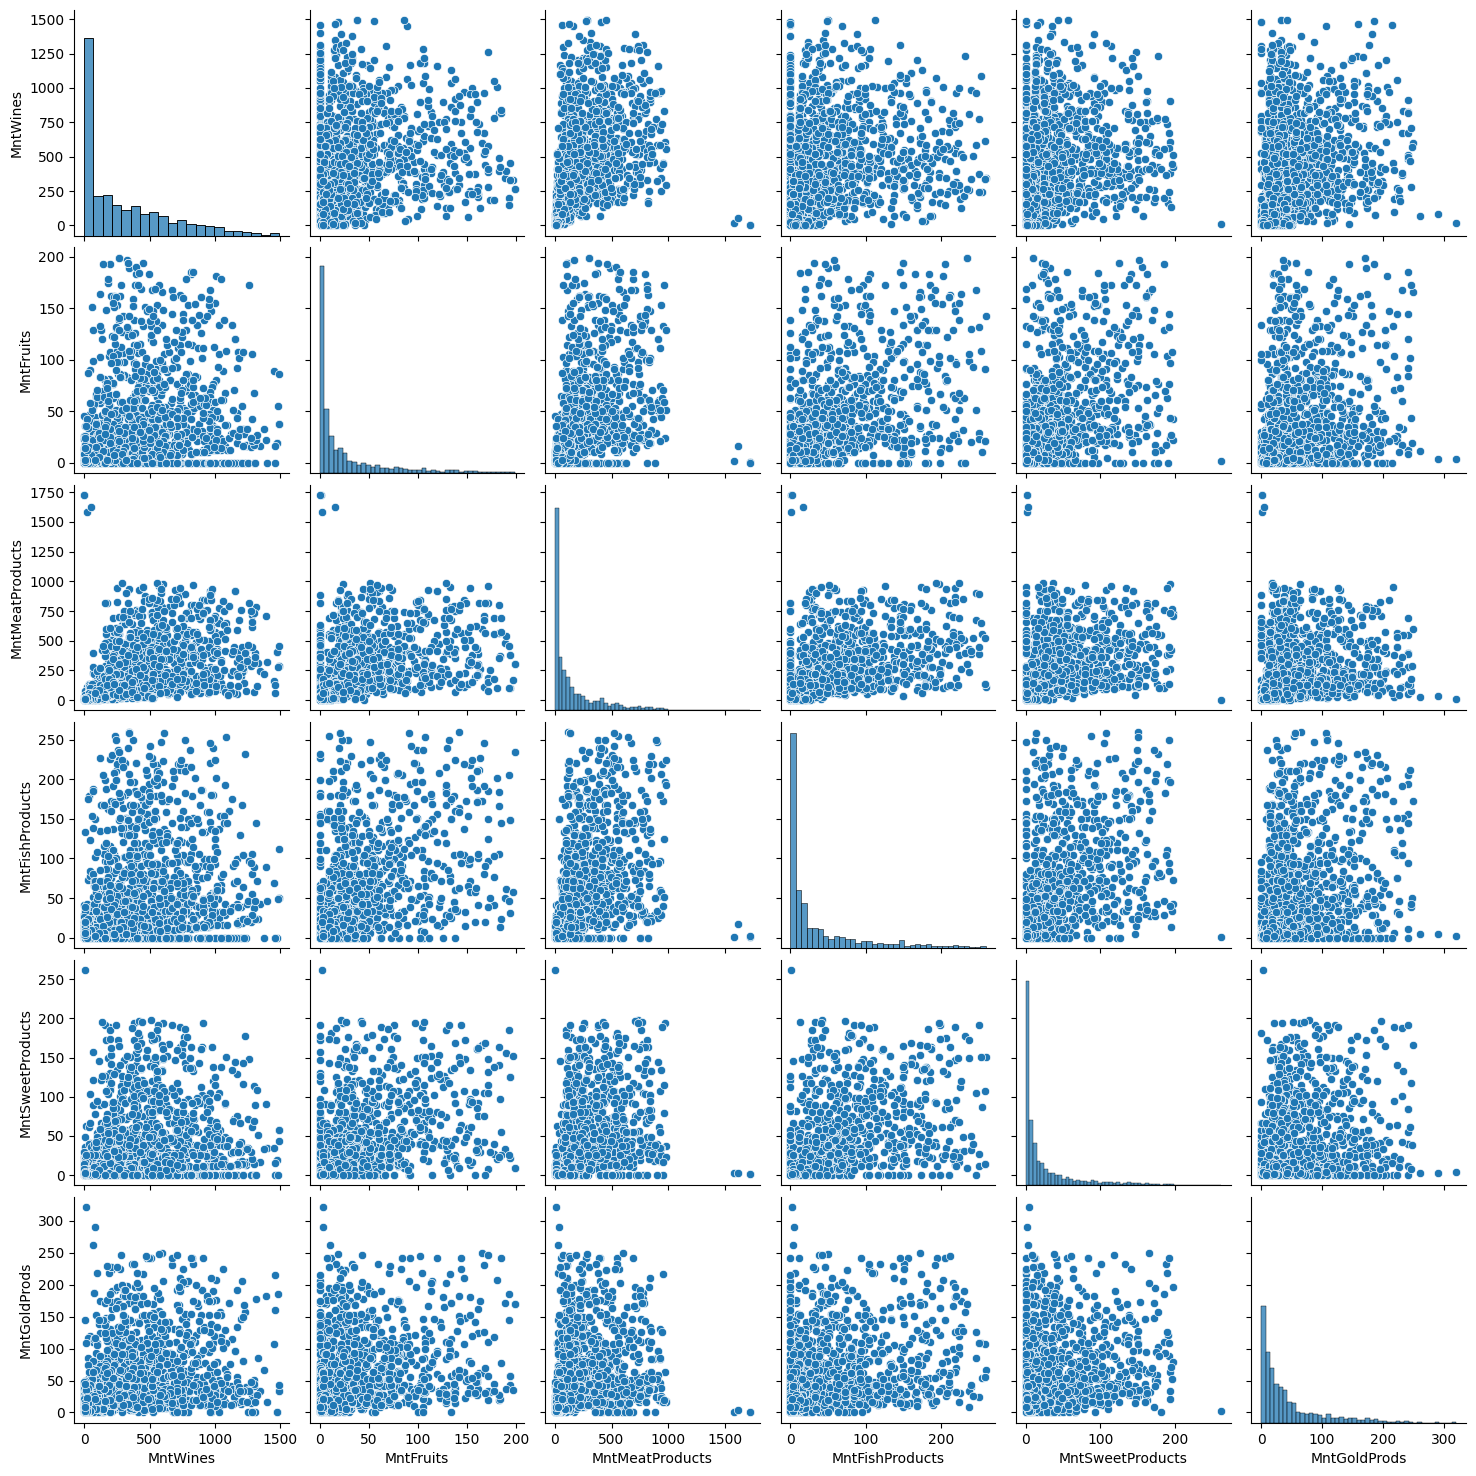

In [147]:
sns.pairplot(data=df[mnt_cols])

In [148]:
df[mnt_cols].corr()

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
MntWines,1.000000,0.387024,0.568860,0.397721,0.390326,0.392731
MntFruits,0.387024,1.000000,0.547822,0.593431,0.571606,0.396487
MntMeatProducts,0.568860,0.547822,1.000000,0.573574,0.535136,0.359446
MntFishProducts,0.397721,0.593431,0.573574,1.000000,0.583867,0.427142
MntSweetProducts,0.390326,0.571606,0.535136,0.583867,1.000000,0.357450
MntGoldProds,0.392731,0.396487,0.359446,0.427142,0.357450,1.000000


In [149]:
df[num_purchases_cols].corr()

,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases
NumDealsPurchases,1.000000,0.241440,-0.012118,0.066107
NumWebPurchases,0.241440,1.000000,0.386868,0.516240
NumCatalogPurchases,-0.012118,0.386868,1.000000,0.517840
NumStorePurchases,0.066107,0.516240,0.517840,1.000000


# 2) data exploration
## checking distributions of data in columns and looking for any interesting patterns or ideas

### 2a) distribution of "MntTotal" and "NumPurchasesTotal"by response

Text(0.5, 1.0, '"MntTotal" Histogram with "Response" as hue')

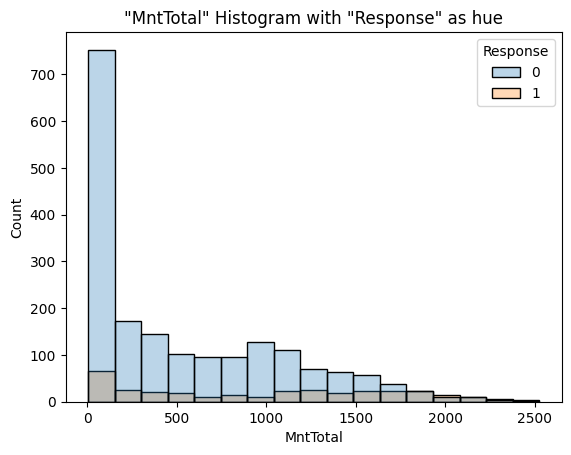

In [37]:
sns.histplot(data=df, x='MntTotal', hue='Response', alpha=0.3)
plt.title('Histogram of "MntTotal" with "Response" as hue')

In [52]:
data.quantile(0.05)

21.0

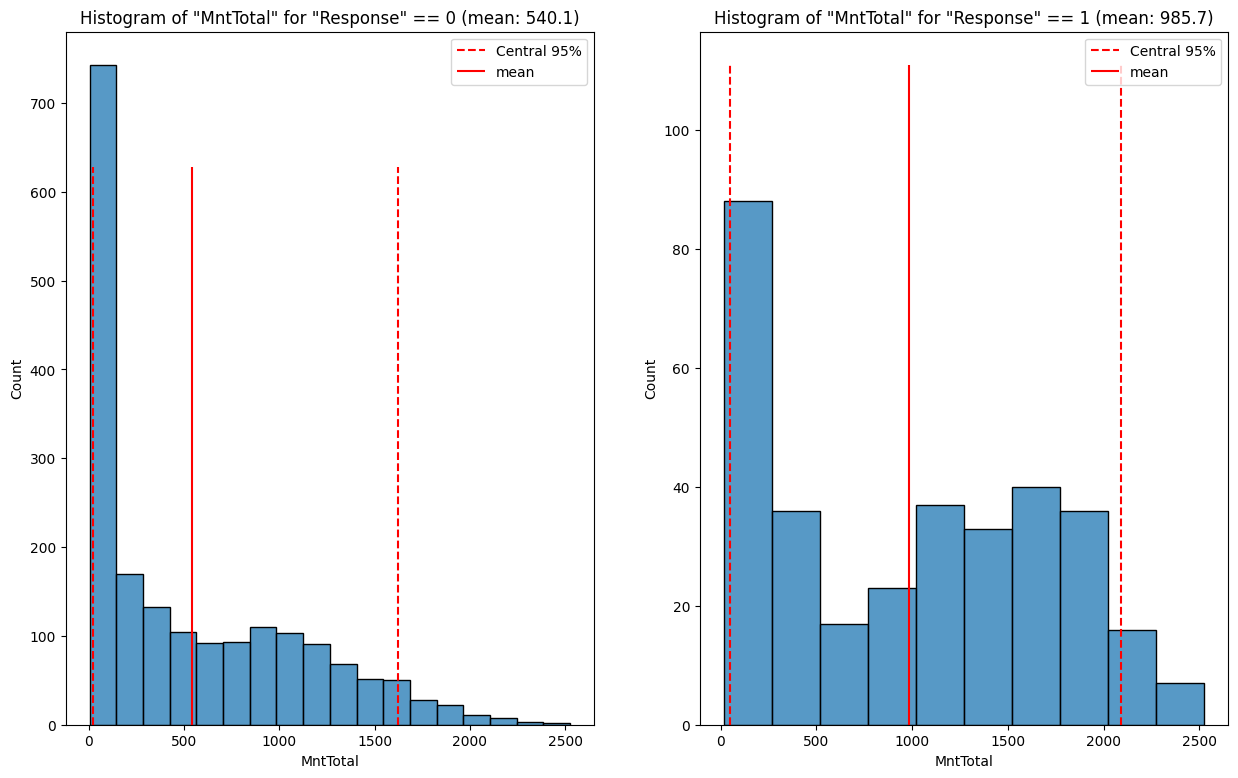

In [146]:
# lets split them into two different subplots to better visualise the "Response" == 1 data

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i in range(2):
    data = df[df['Response']==i]['MntTotal']
    obs_count = data.shape[0]
    vertical_line_height = obs_count/3
    
    percentile_5 = data.quantile(0.05)
    percentile_95= data.quantile(0.95)
    mean = np.mean(data)
    
    sns.histplot(x=data, ax=ax[i])
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', label='Central 95%')
    ax[i].vlines(x=np.mean(data), ymin=0, ymax=vertical_line_height, color='red', label='mean')    
    
    ax[i].set_title(f'Histogram of "MntTotal" for "Response" == {i} (mean: {mean:.1f})')
    ax[i].legend()

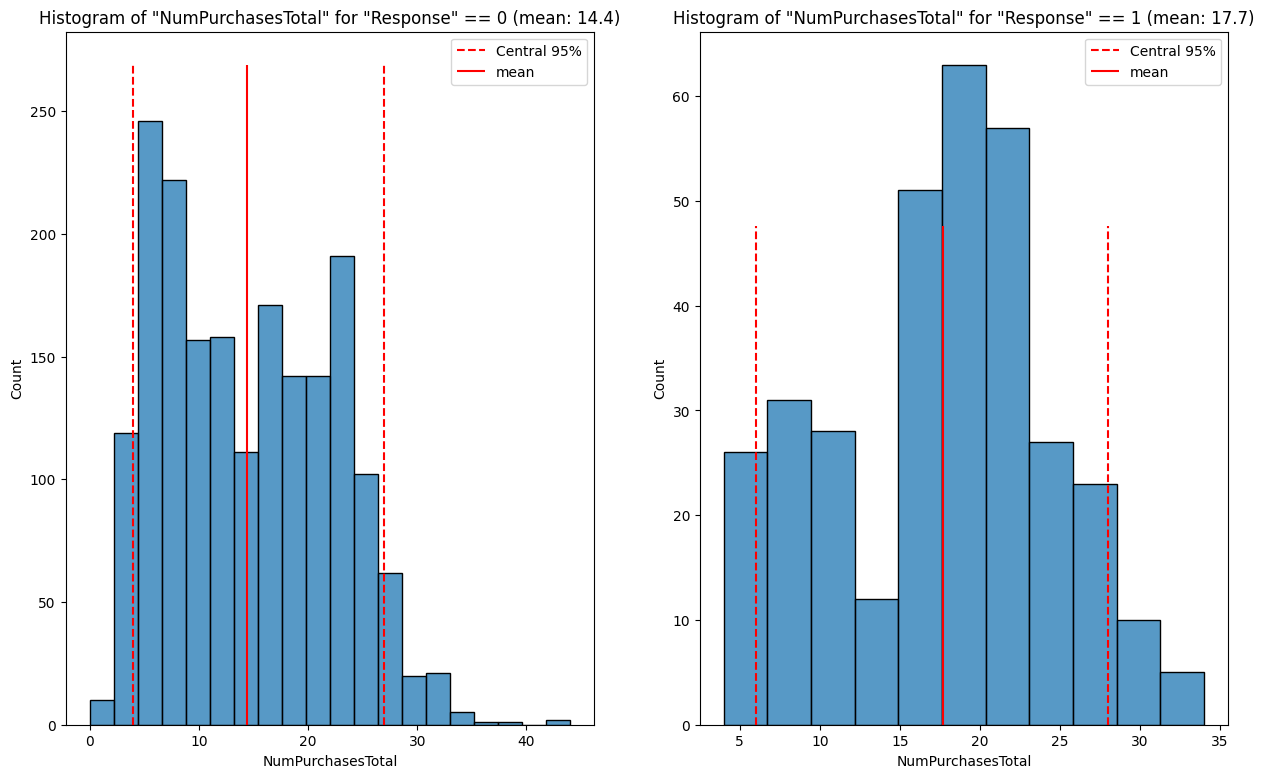

In [144]:
# do the same for "TotalPurchases"

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i in range(2):
    data = df[df['Response']==i]['NumPurchasesTotal']
    obs_count = data.shape[0]
    vertical_line_height = obs_count/7
    
    percentile_5 = data.quantile(0.05)
    percentile_95= data.quantile(0.95)
    mean = np.mean(data)
    
    sns.histplot(x=data, ax=ax[i])
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', label='Central 95%')
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', label='mean')
    
    ax[i].set_title(f'Histogram of "NumPurchasesTotal" for "Response" == {i} (mean: {mean:.1f})')
    ax[i].legend()

### as expected, the customers who accepted the offer in the most recent campaign tend to spend more than those who didn't (nearly 2x as much on average), however they didn't make many more purchases (17.7 vs. 14.4) so they we're making higher value purchases
### maybe we can focus more of our marketing efforts on higher spend customers in future, they should be the first to be notified about any new offers
#### sometimes a company may try to reach new customers or build a new customer base/demographic, however it's usually easier to "swim with the tide" and ensure a healthy focus on current high value customers

In [ ]:
### 2b) let's see if Mnt_ 

### 2c) countplot of "AcceptedTotal" by response

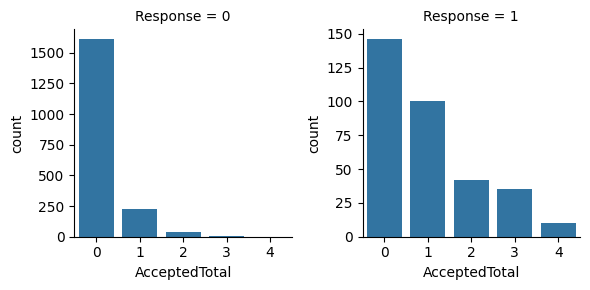

In [72]:
sns.FacetGrid(data=df, col='Response', sharey=False).map_dataframe(sns.countplot, x='AcceptedTotal')

In [113]:
response_group['AcceptedTotal'].unique()

array([0, 1, 2, 4, 3], dtype=int64)

In [119]:
for i in range(2):
    response_group = df[df['Response']==i]
    total_in_response_group = response_group.shape[0]
    
    print(f'Group: {i}')    
    for j in range(5):        
        pct = response_group[response_group['AcceptedTotal'] == j].shape[0] / total_in_response_group
        print(f'Percentage of accepted total == {j}: {pct:.2f}')

Group: 0
Percentage of accepted total == 0: 0.86
Percentage of accepted total == 1: 0.12
Percentage of accepted total == 2: 0.02
Percentage of accepted total == 3: 0.00
Percentage of accepted total == 4: 0.00
Group: 1
Percentage of accepted total == 0: 0.44
Percentage of accepted total == 1: 0.30
Percentage of accepted total == 2: 0.13
Percentage of accepted total == 3: 0.11
Percentage of accepted total == 4: 0.03


### having accepted offers before is a good indicator of accepting more coupons (57% percent of "Response" == 1 customers had previously accepted an offer)
### not much of a surprise, but again, it might be worth focussing on these customers, maybe creating a loyalty program

### 3a) segment the responses by campaign to see if any previous campaign was particularly successful
#### if so, what was the messaging of the campaign and what were the offers

In [124]:
df['AcceptedCmp1'].unique()

array([0, 1], dtype=int64)

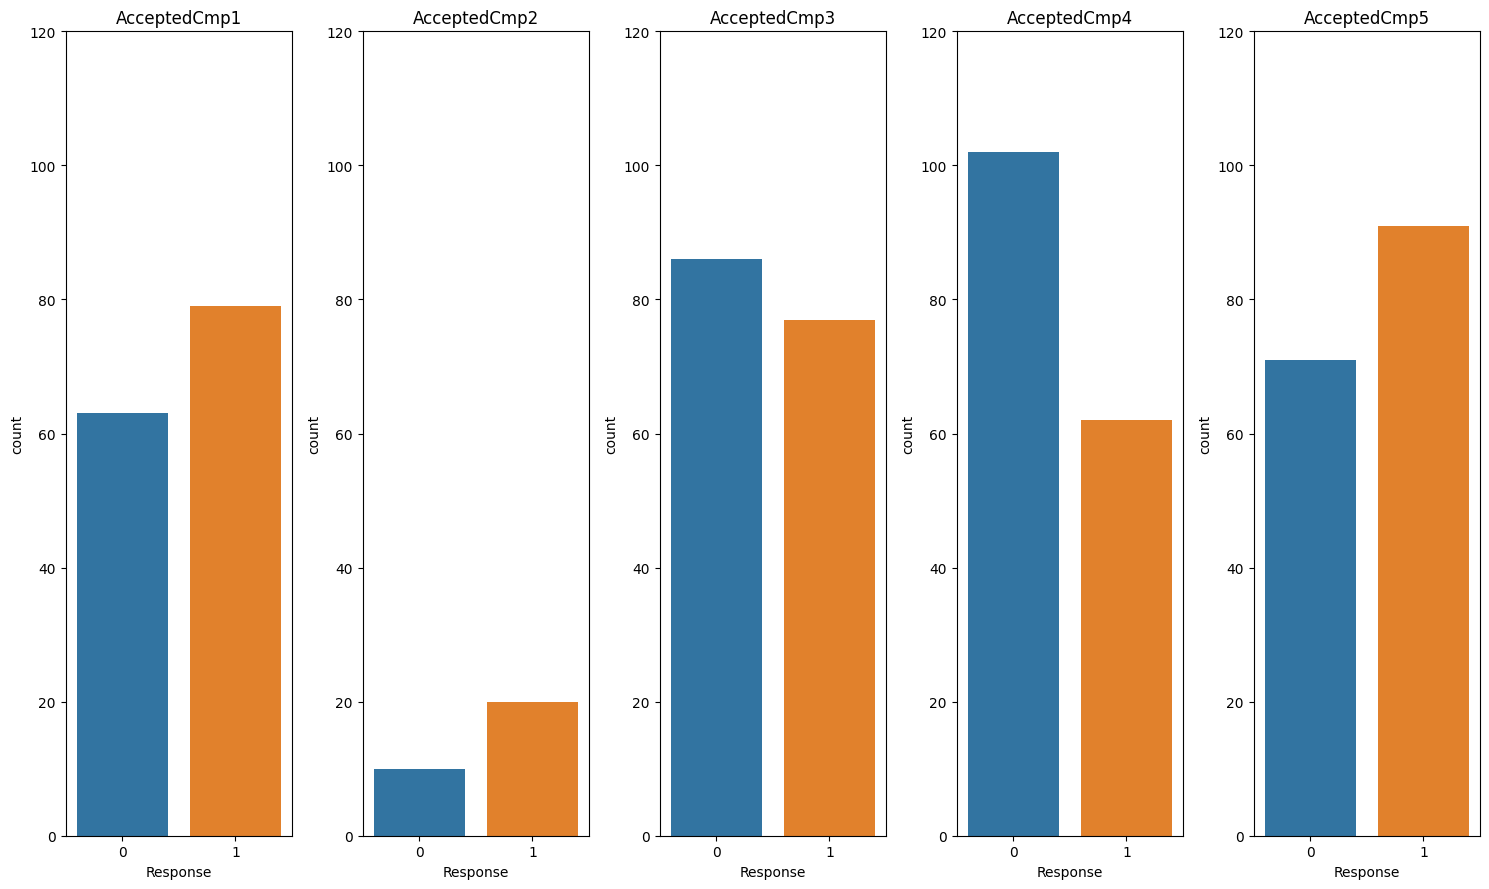

In [260]:
fig, ax = plt.subplots(1, 5, figsize=(15, 9))

for i in range(5):
    sns.countplot(data=df[df[f'AcceptedCmp{i+1}'] == 1], x='Response', ax=ax[i])
    ax[i].set_title(f'AcceptedCmp{i+1}')
    ax[i].set_ylim(top=120)
    
plt.tight_layout()

### success in campaigns one, two and five seems to have a higher correlation to success in the current campaign than campaigns three and four, but success in ANY campaign leads to higher uptake than otheriwse
### what was the nature of those campaigns and how are they related to this one? Is there anything we can learn from those campaigns?

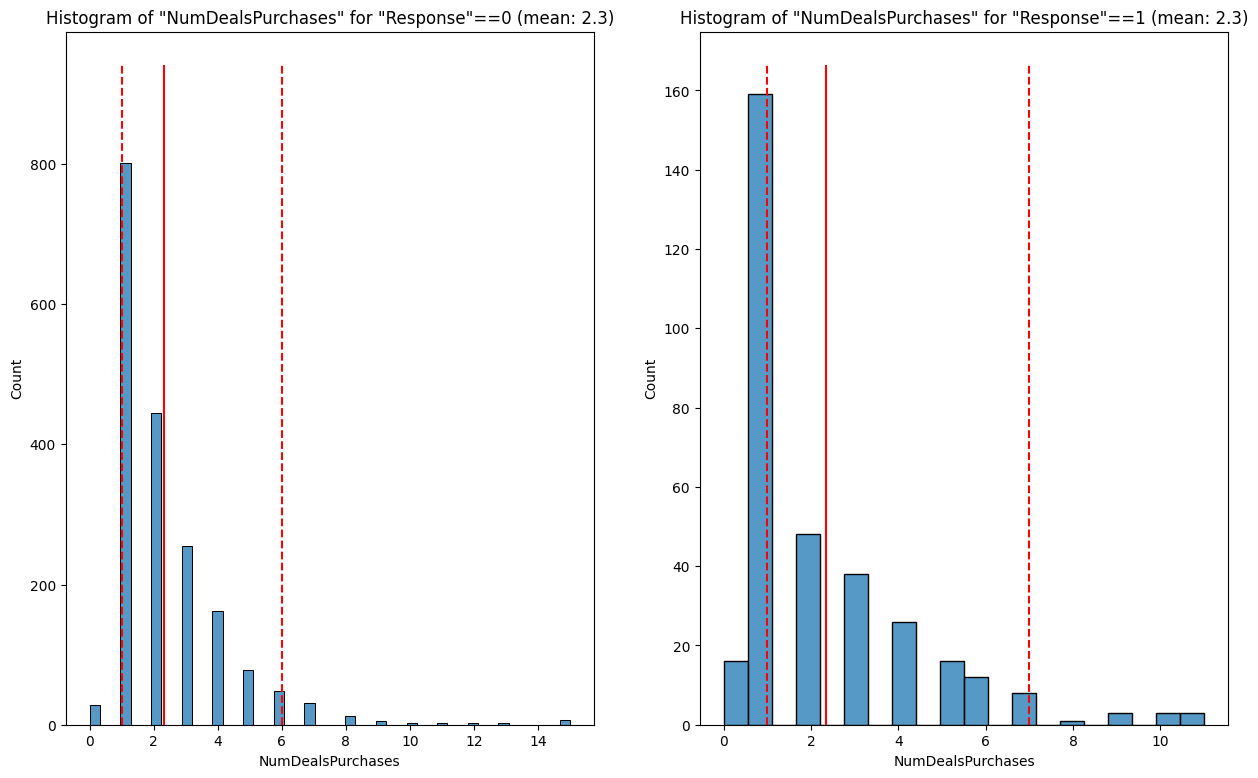

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(15,9))

for i in range(2):
    sns.histplot(data=df[df['Response']==i], x='NumDealsPurchases', ax=ax[i])
    
    mean = np.mean(df[df['Response']==i]['NumDealsPurchases'])
    percentile_5 = df[df['Response']==i]['NumDealsPurchases'].quantile(0.05)
    percentile_95 = df[df['Response']==i]['NumDealsPurchases'].quantile(0.95)
    obs_count = df[df['Response']==i]['NumDealsPurchases'].shape[0]
    vertical_line_height = obs_count/2
    
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--')
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red')
    
    ax[i].set_title(f'Histogram of "NumDealsPurchases" for "Response"=={i} (mean: {mean:.1f})')

### surprisingly, the number of deals pruchases doesn't tell us much about whether a customer would accept the most recent offer

### 2d) check out some countplots to see if anything else splits the "Response" data well

In [164]:
df['ChildrenTotal'].unique()

array([0, 2, 1, 3], dtype=int64)

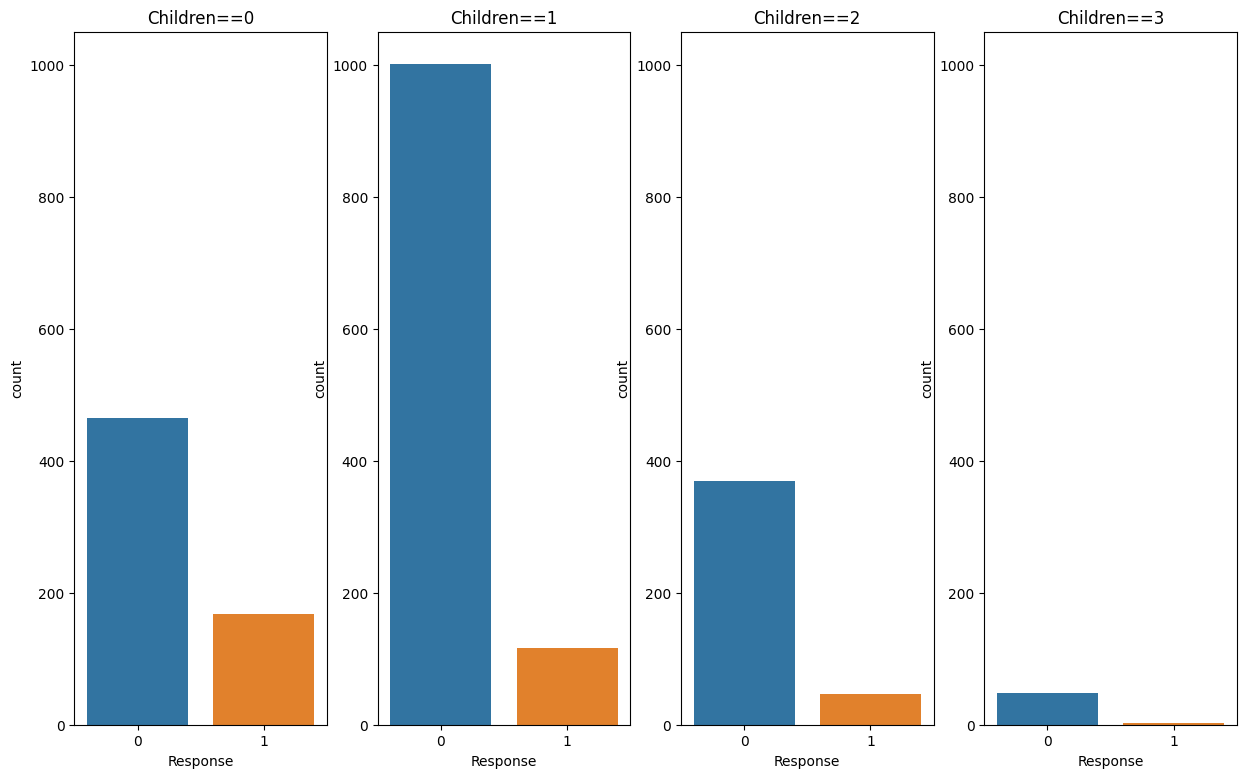

In [166]:
fig, ax = plt.subplots(1, 4, figsize=(15, 9))

for i in range(4):
    sns.countplot(data=df[df[f'ChildrenTotal'] == i], x='Response', ax=ax[i])
    ax[i].set_title(f'Children=={i}')
    ax[i].set_ylim(top=1050)

### highest count of "Response"==1 (and highest proportion of "Response"==1 within their group) is from those with 0 children. Maybe they have more disposable income, maybe they're just less careful with their money.

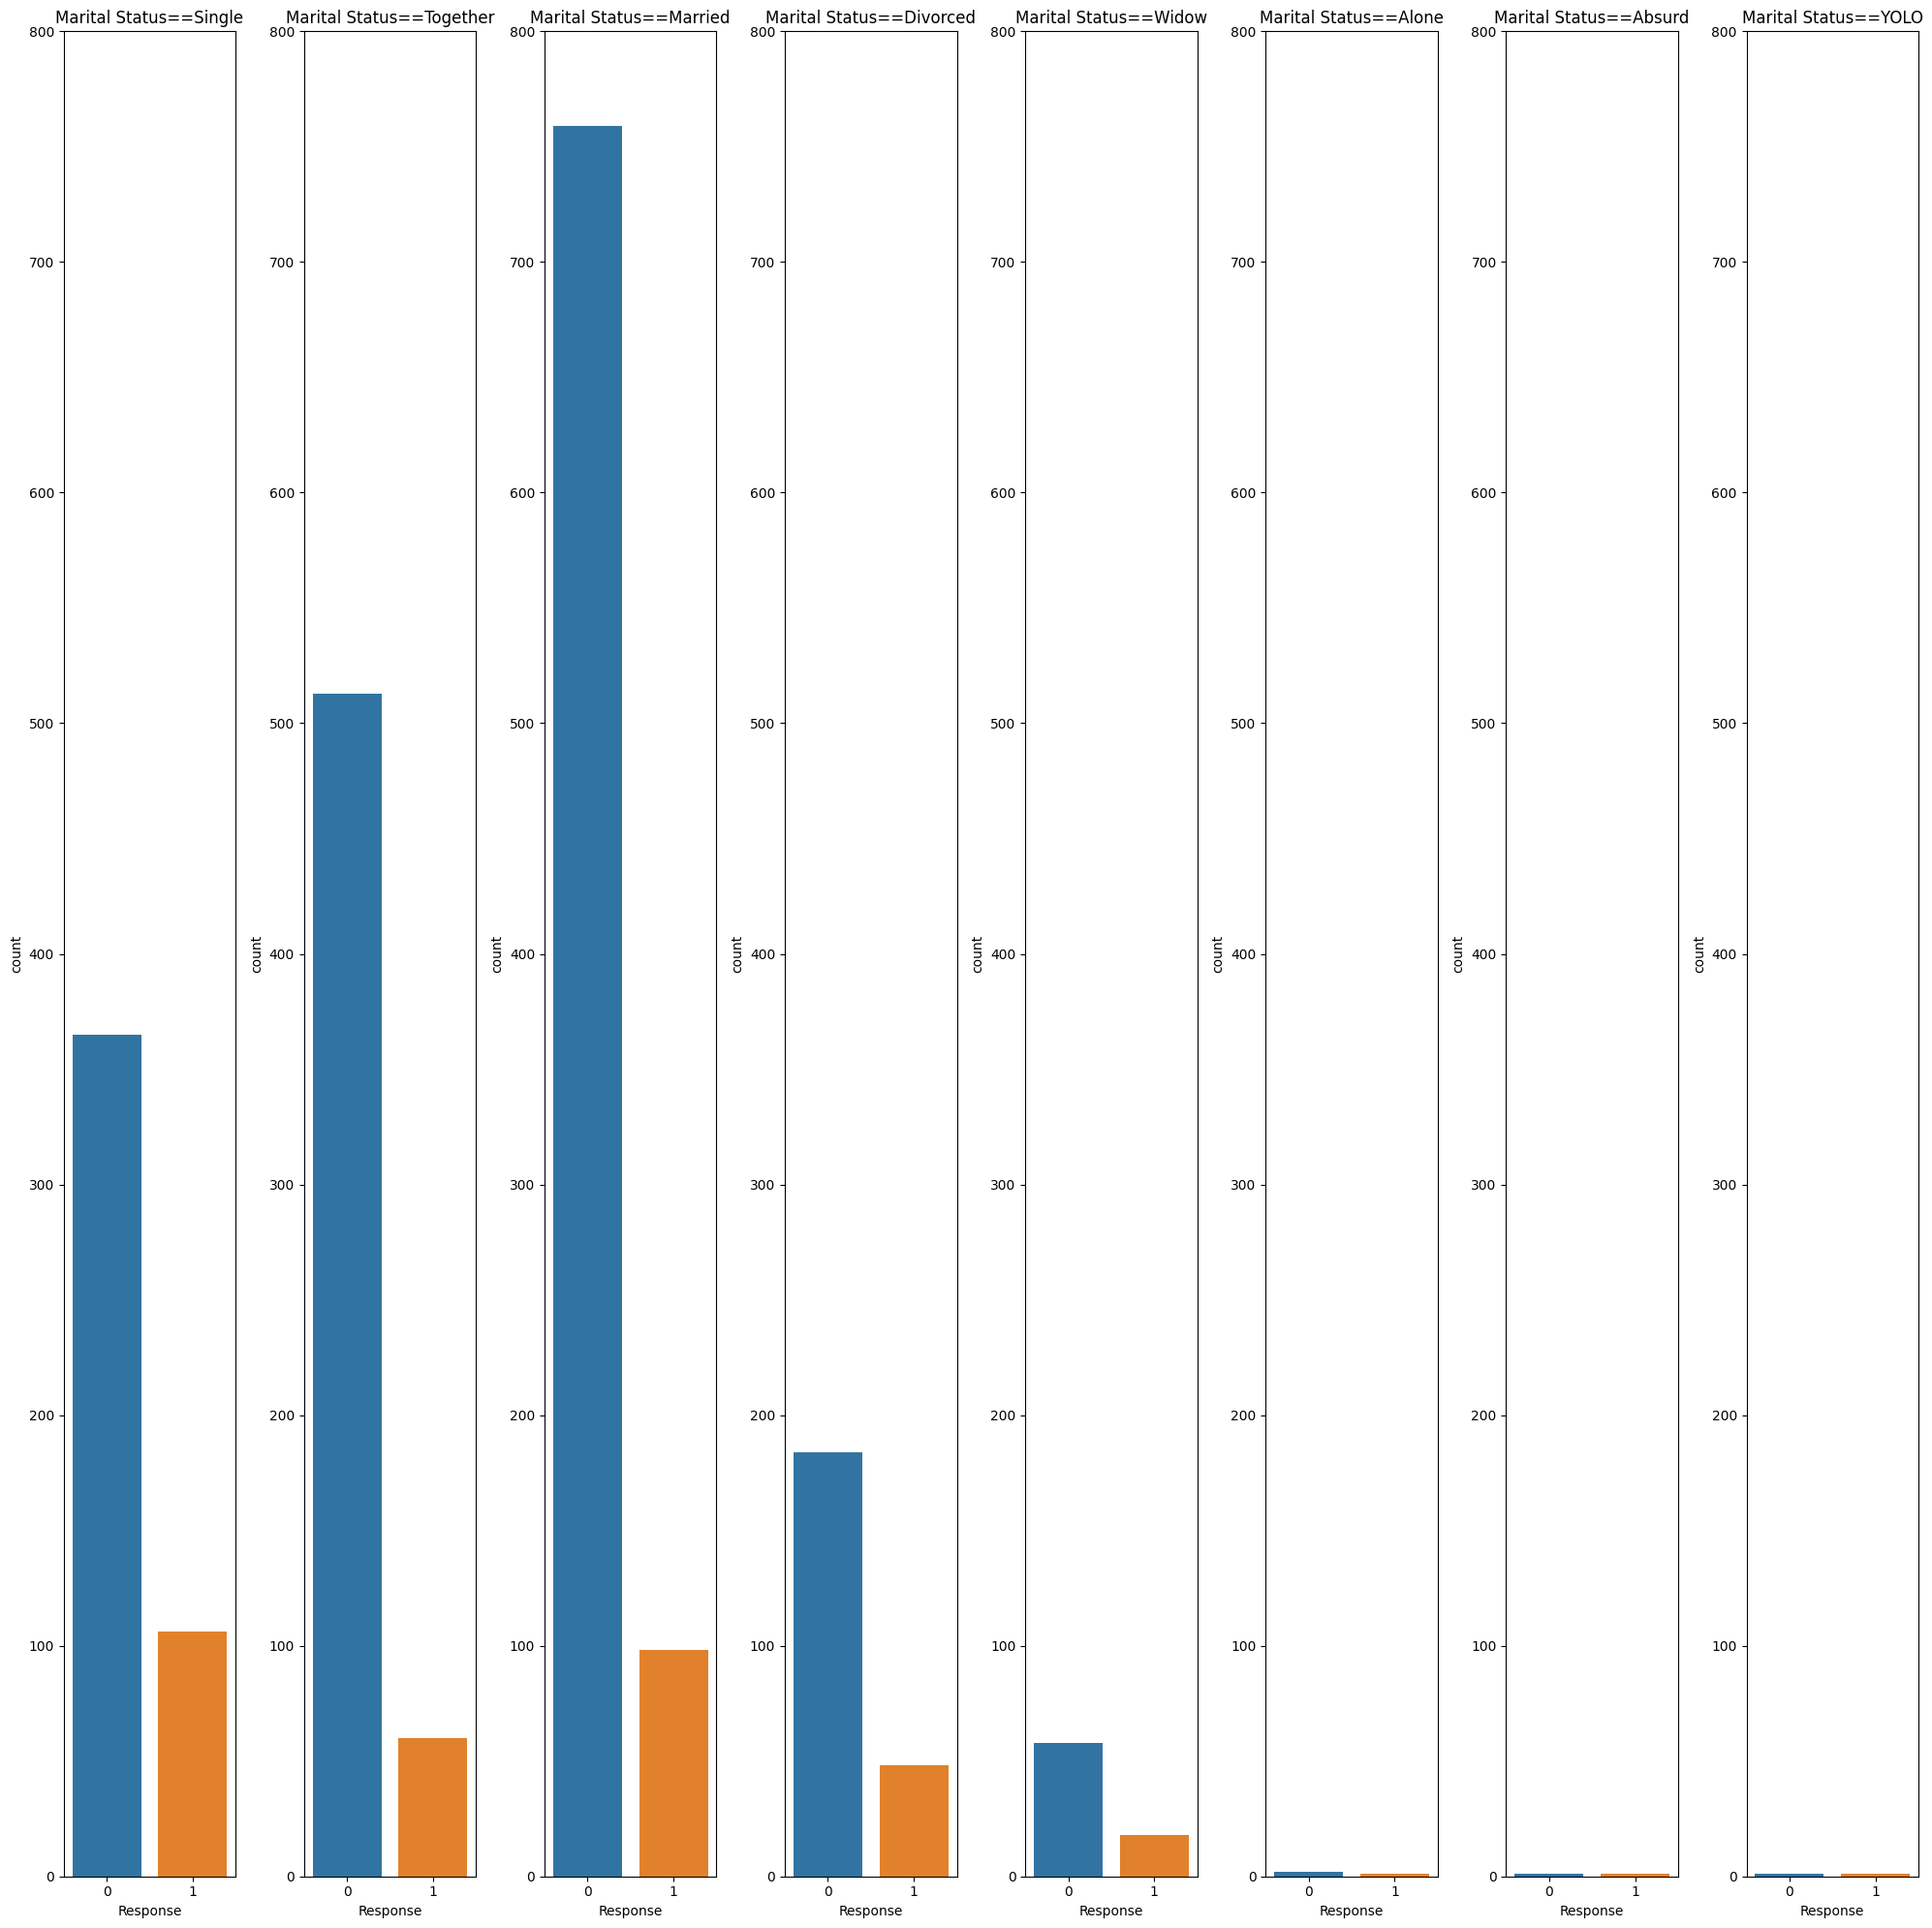

In [178]:
statuses = df['Marital_Status'].unique()
category_count = df['Marital_Status'].nunique()

fig, ax = plt.subplots(1, category_count, figsize=(20, 20))

for i in range(category_count):
    sns.countplot(data=df[df['Marital_Status'] == statuses[i]], x='Response', ax=ax[i])
    ax[i].set_title(f'Marital Status=={statuses[i]}')
    ax[i].set_ylim(top=800)
    
plt.tight_layout()

In [214]:
df_by_mstat = df.groupby(['Marital_Status'])['Response'].value_counts(normalize=True)
df_by_mstat

Marital_Status  Response
Absurd          0           0.500000
                1           0.500000
Alone           0           0.666667
                1           0.333333
Divorced        0           0.793103
                1           0.206897
Married         0           0.885648
                1           0.114352
Single          0           0.774947
                1           0.225053
Together        0           0.895288
                1           0.104712
Widow           0           0.763158
                1           0.236842
YOLO            0           0.500000
                1           0.500000
Name: Response, dtype: float64

In [192]:
statuses[i]

'YOLO'

In [215]:
df_by_mstat.loc[statuses[i]]

0.7749469214437368

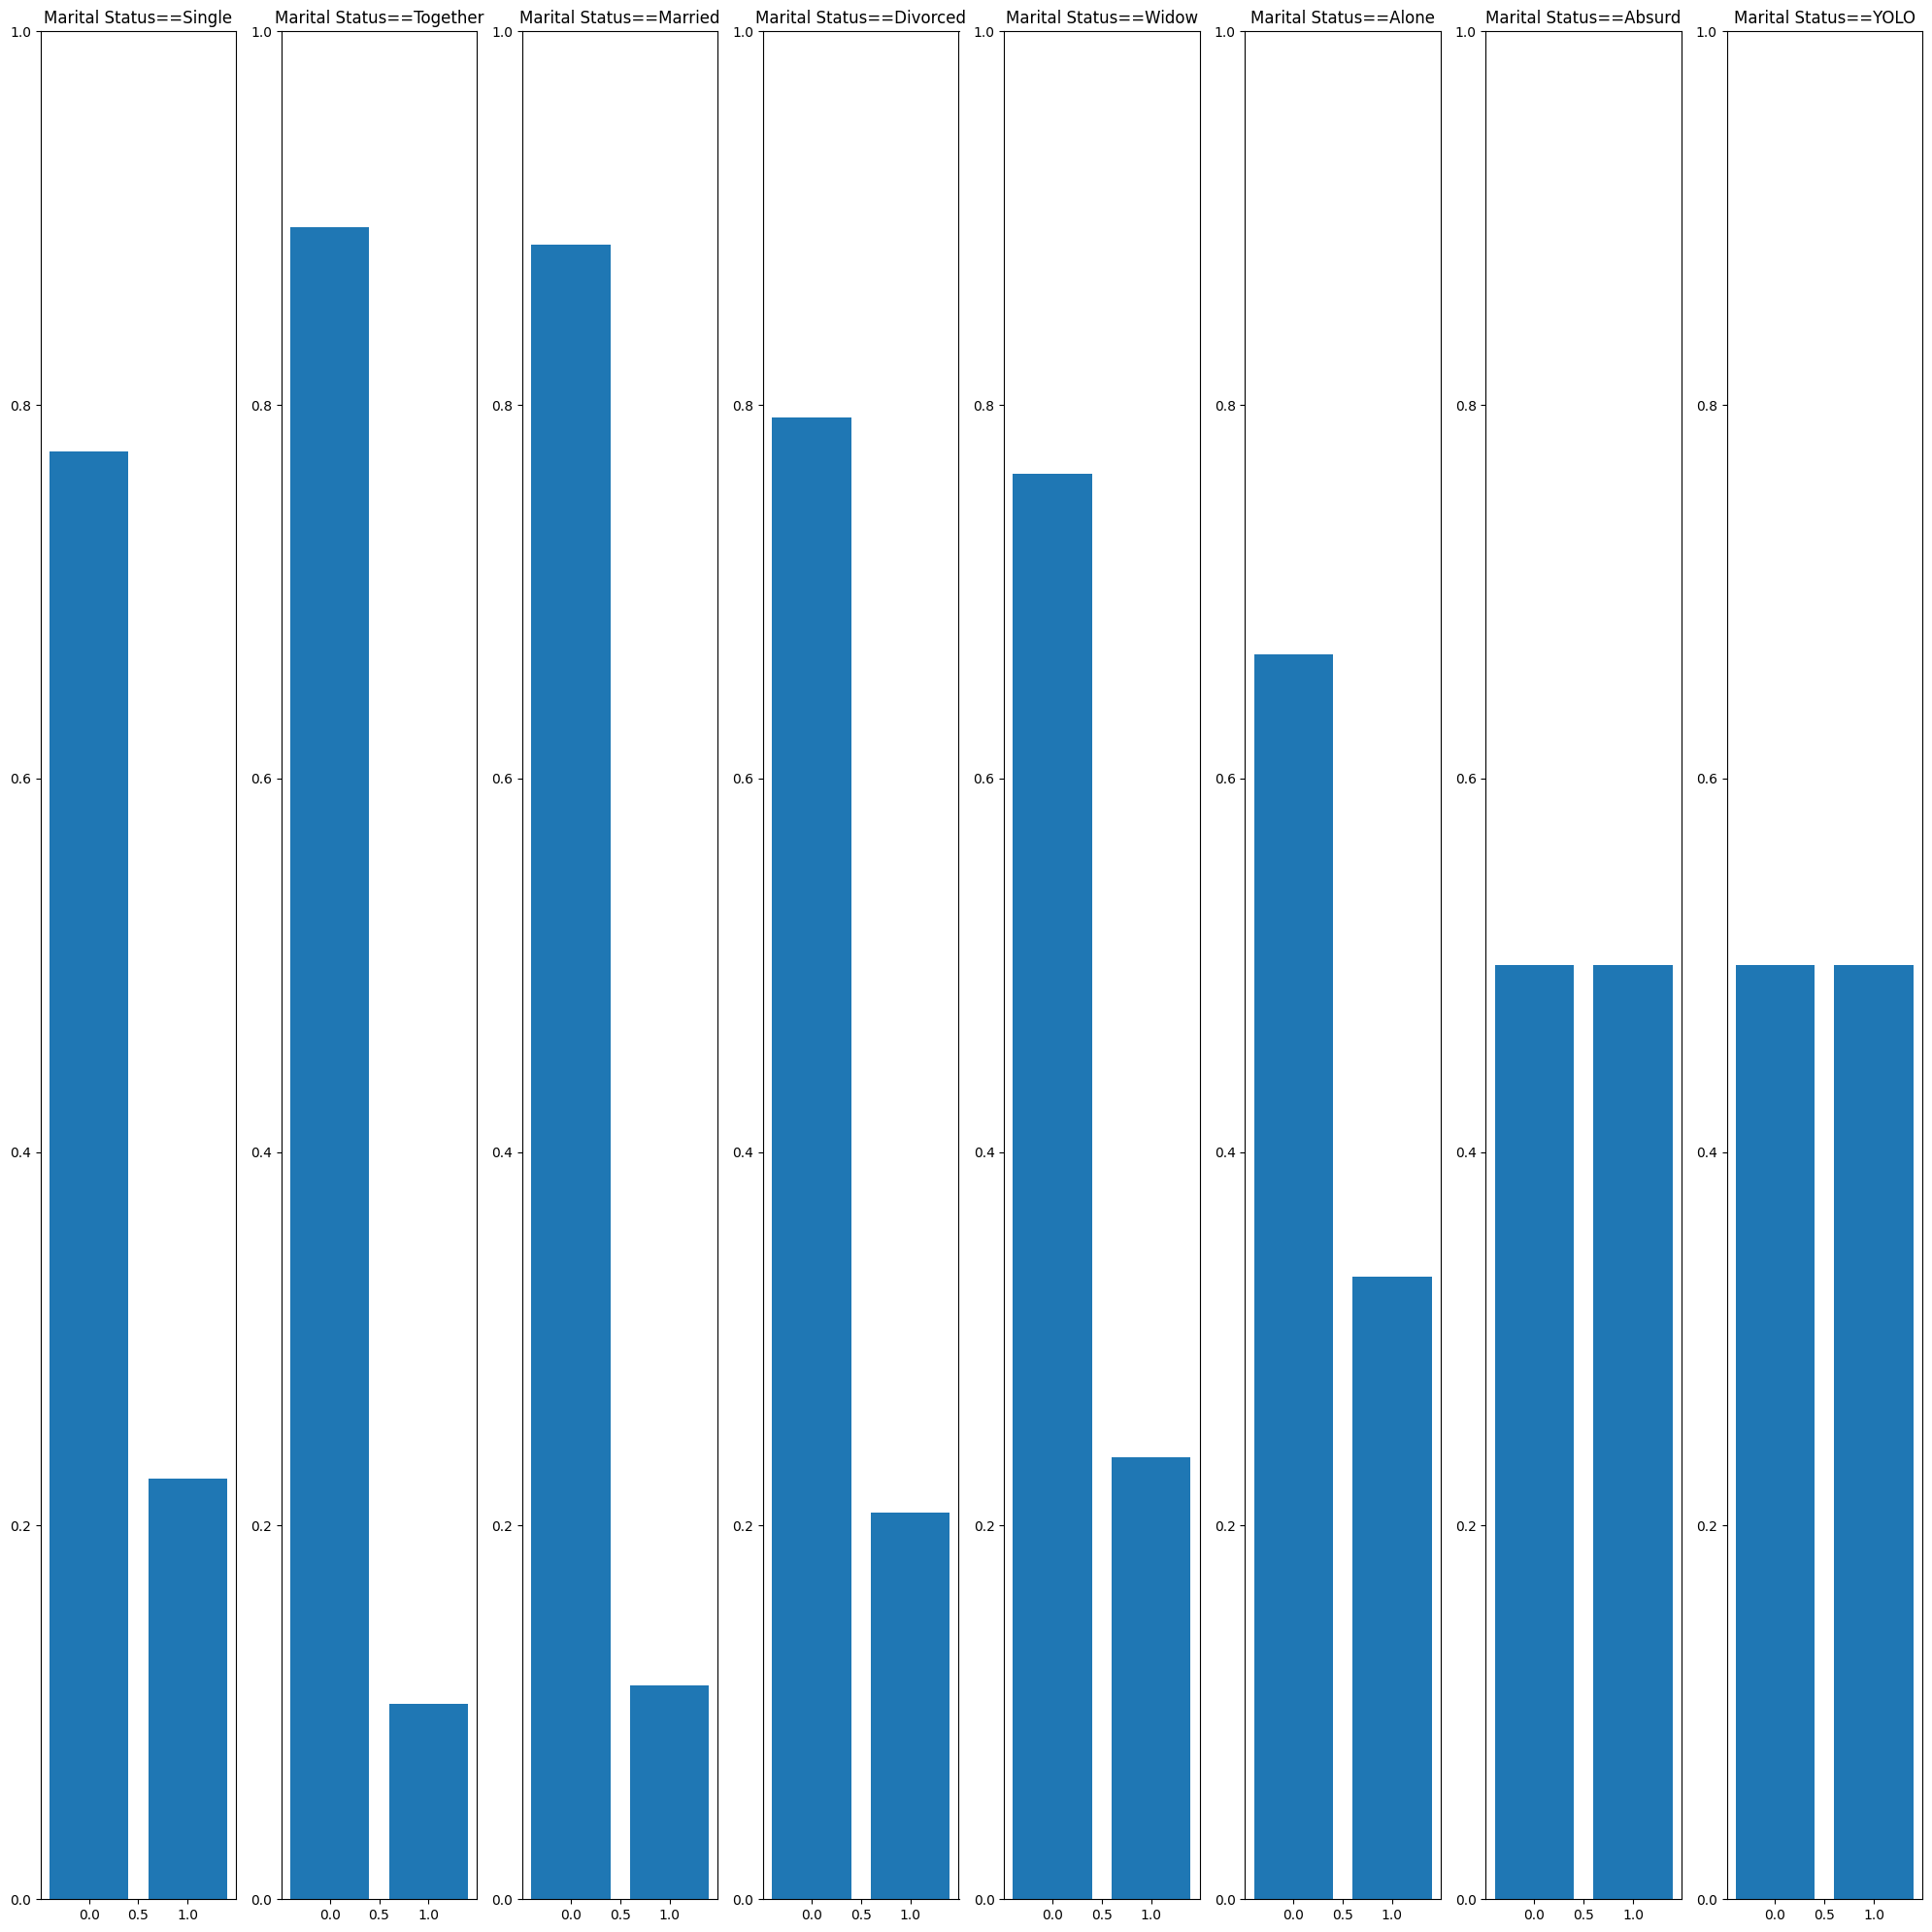

In [220]:
fig, ax = plt.subplots(1, category_count, figsize=(20, 20))

for i in range(category_count):
    #sns.countplot(data=df_by_mstat.loc[statuses[i]], x=[0, 1], ax=ax[i])
    data = df[df['Marital_Status'] == statuses[i]]
    heights = [
        data[data['Response'] == 0].shape[0]/data.shape[0],
        data[data['Response'] == 1].shape[0]/data.shape[0]
    ]
    
    
    ax[i].bar(x=[0, 1], height=heights)
    ax[i].set_title(f'Marital Status=={statuses[i]}')
    ax[i].set_ylim(top=1.0)
    
plt.tight_layout()

Text(0.5, 1.0, 'Proportion of "Response"==1 for Single AND No Children: 0.4')

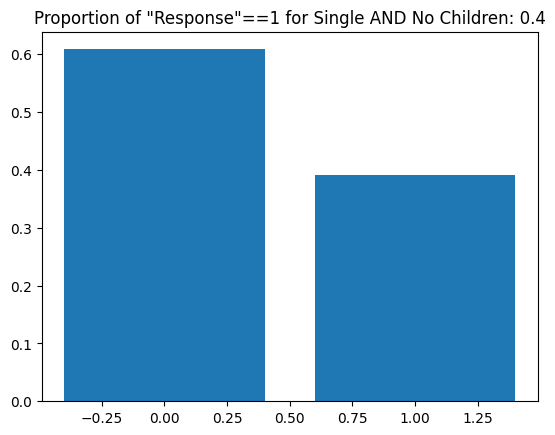

In [243]:
m_status = 'Single'
x_no_children = df.query(f'Marital_Status==@m_status and ChildrenTotal==0')
obs_count = x_no_children.shape[0]

heights = [1-(x_no_children['Response'].sum()/obs_count), x_no_children['Response'].sum()/obs_count]

plt.bar(x=[0, 1], height=heights)
plt.title(f'Proportion of "Response"==1 for {m_status} AND No Children: {x_no_children["Response"].sum()/obs_count:.1f}')

Text(0.5, 1.0, 'Proportion of "Response"==1 for Divorced AND No Children: 0.4')

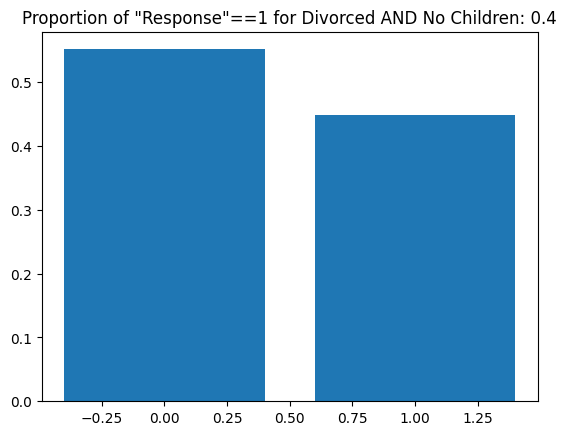

In [244]:
m_status = 'Divorced'
x_no_children = df.query(f'Marital_Status==@m_status and ChildrenTotal==0')
obs_count = x_no_children.shape[0]

heights = [1-(x_no_children['Response'].sum()/obs_count), x_no_children['Response'].sum()/obs_count]

plt.bar(x=[0, 1], height=heights)
plt.title(f'Proportion of "Response"==1 for {m_status} AND No Children: {x_no_children["Response"].sum()/obs_count:.1f}')

### Looks like single and divorced people with no children have the highest liklihood of taking up the offer

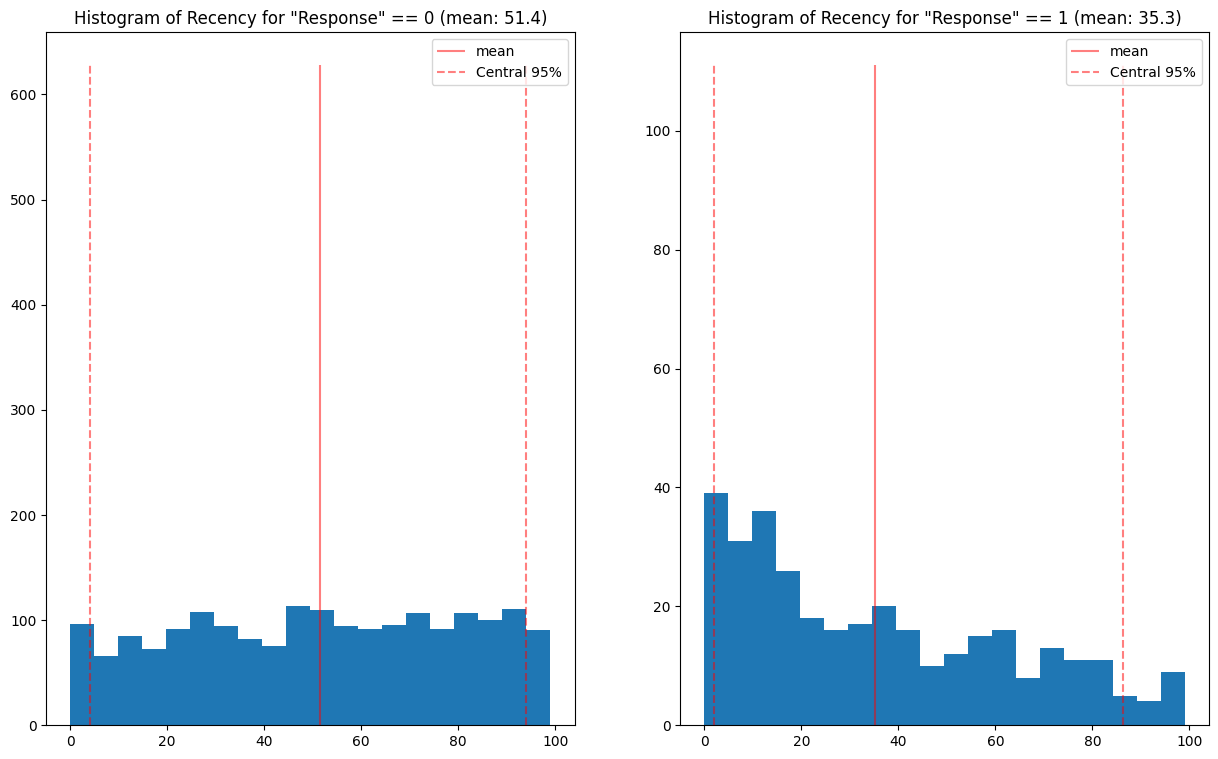

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))


for i in range(2): 
    data = df[df['Response'] == i]['Recency']    
    
    obs_count = data.shape[0]
    vertical_line_height = obs_count/3
    mean = np.mean(data)
    percentile_5 = data.quantile(0.05)
    percentile_95 = data.quantile(0.95)
    
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, label='mean', color='red', alpha=0.5)
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, label='Central 95%', color='red', linestyle='--', alpha=0.5)
    
    ax[i].hist(data, bins=20)
    ax[i].set_title(f'Histogram of Recency for "Response" == {i} (mean: {mean:.1f})')
    ax[i].legend()

### those who took up the offer have a lower average "Recency" (i.e. made their last purchase more recently than those who did not take up the offer). Maybe they're more loyal/frequent customers in general

### does income affect response?

(0.0, 200000.0)

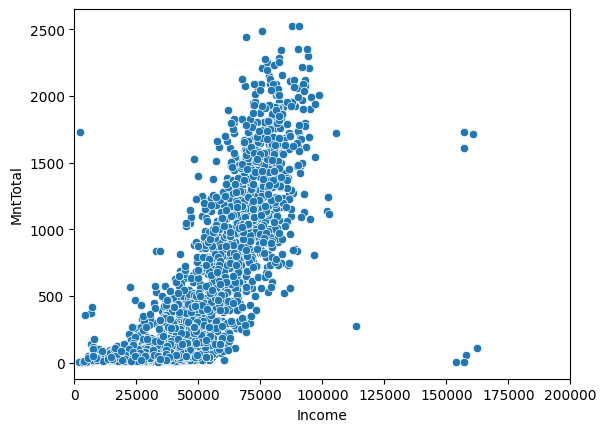

In [1024]:
sns.scatterplot(data=df, x='Income', y='MntTotal')
plt.xlim(0, 200000)

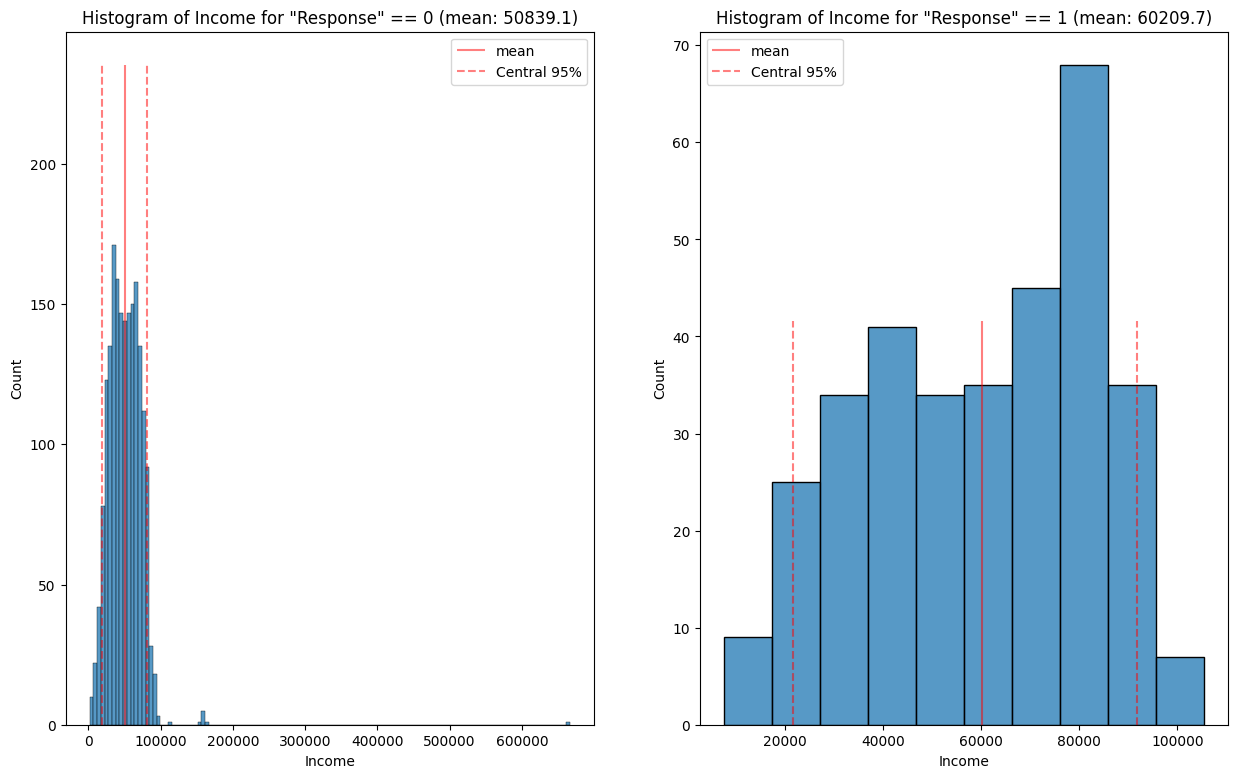

In [302]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i in range(2):
    data = df[df['Response']==i]
    
    obs_count = data.shape[0]
    vertical_line_height = obs_count/8
    
    mean = data['Income'].mean()
    percentile_5 = data['Income'].quantile(0.05)
    percentile_95 = data['Income'].quantile(0.95)
    
    sns.histplot(data=data, x='Income', ax=ax[i])
    ax[i].set_title(f'Histogram of Income for "Response" == {i} (mean: {mean:.1f})')
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', alpha=0.5, label='mean')
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', alpha=0.5, label='Central 95%')
    ax[i].legend()

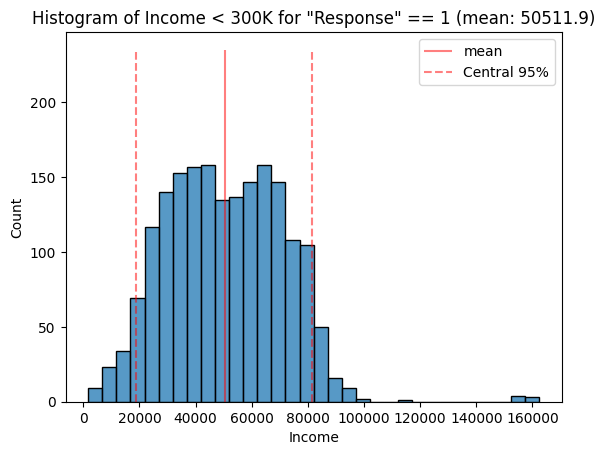

In [304]:
data = df[df['Response'] == 0]
data = data[data['Income'] < 300000]

obs_count = data.shape[0]
vertical_line_height = obs_count/8

mean = data['Income'].mean()
percentile_5 = data['Income'].quantile(0.05)
percentile_95 = data['Income'].quantile(0.95)

sns.histplot(data=data, x='Income')

plt.title(f'Histogram of Income < 300K for "Response" == {i} (mean: {mean:.1f})')
plt.vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', alpha=0.5, label='mean')
plt.vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', alpha=0.5, label='Central 95%')
plt.legend()

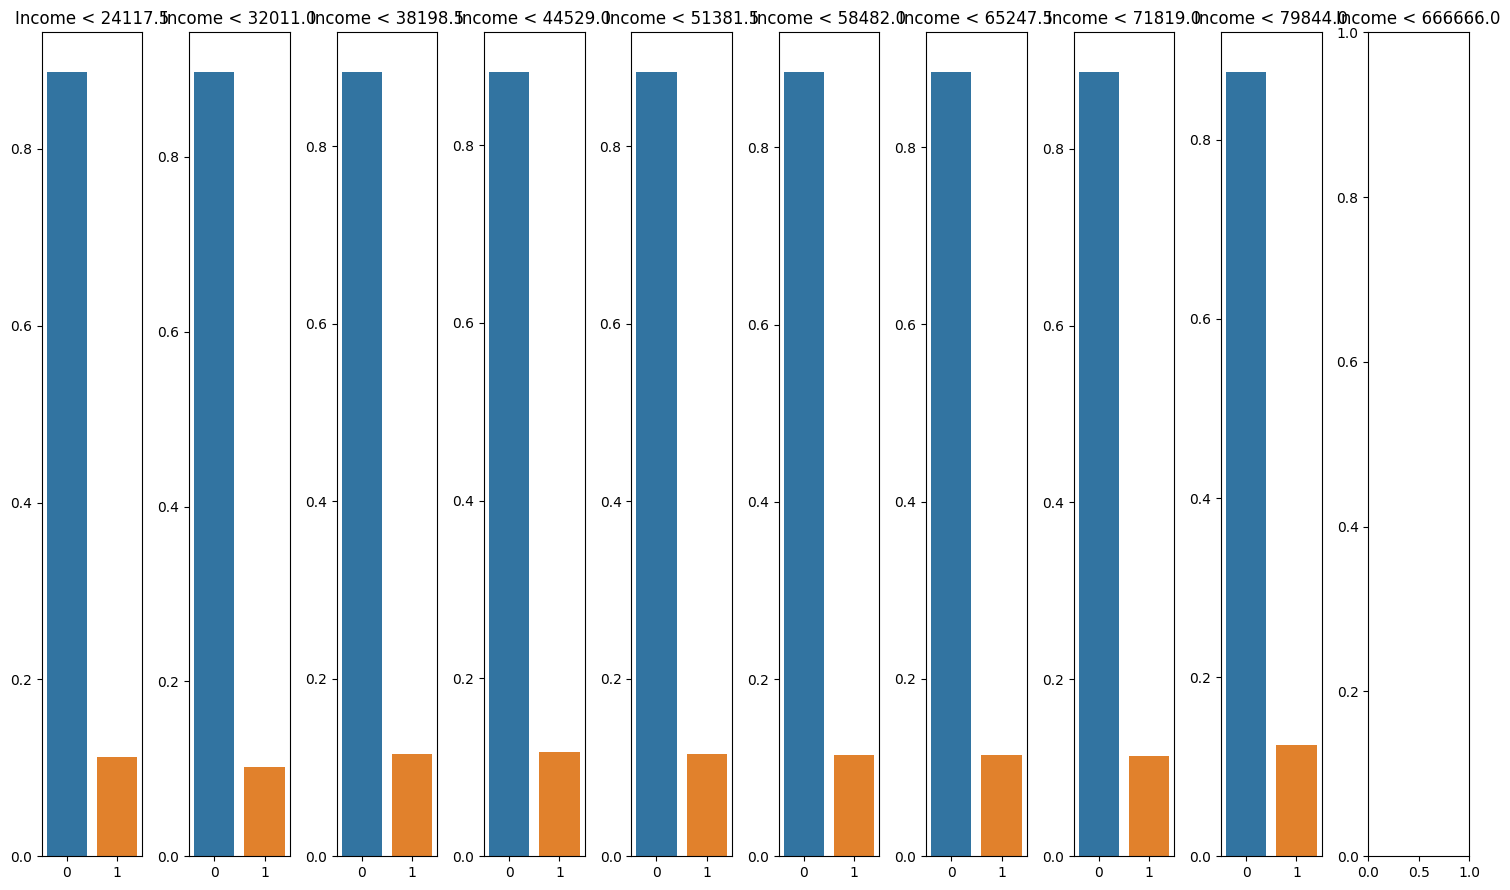

In [770]:
data_column = 'Income'
quantile_count = 10
quantile_bounds_upper = [df[data_column].quantile(i/100) for i in np.linspace(10, 100, 10)]
quantile_bounds_lower = [0] + [(bound - quantile_bounds_upper[i]) for i, bound in enumerate(quantile_bounds_upper[1:])]

fig, ax = plt.subplots(1, quantile_count, figsize=(15, 9))

for i in range(quantile_count):
    data = df.query('Income > @quantile_bounds_lower[@i] and Income < @quantile_bounds_upper[@i]')
    
    obs_count = data.shape[0]
    
    try:
        height1 = data[data['Response']==0].shape[0]/obs_count
        height2 = data[data['Response']==1].shape[0]/obs_count
        sns.barplot(x=[0, 1], y=[height1, height2], ax=ax[i])
    except ZeroDivisionError:
        pass
    ax[i].set_title(f'{data_column} < {quantile_bounds_upper[i]}')
    #ax[i].set_ylim(0, 0.3)
    
plt.tight_layout()

### does customer time with the company affect response?

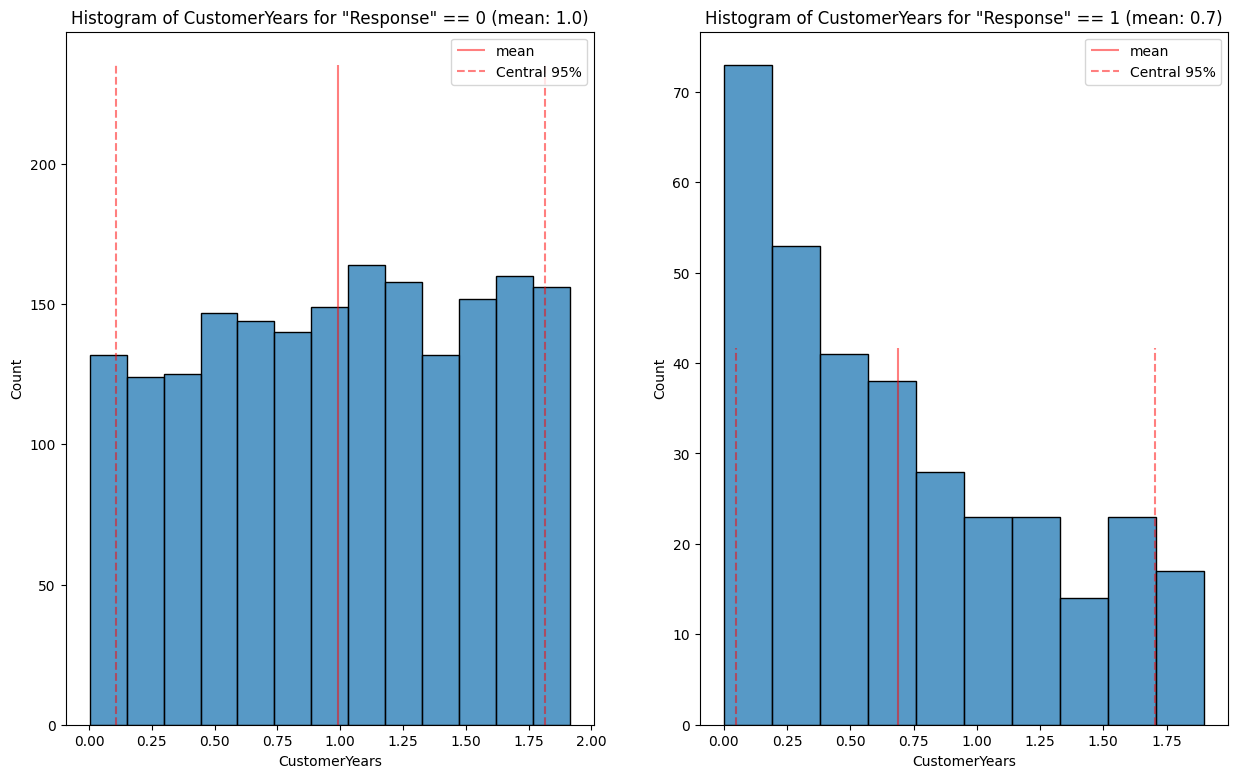

In [326]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))

data_column = 'CustomerYears'

for i in range(2):
    data = df[df['Response']==i]
    
    obs_count = data.shape[0]
    vertical_line_height = obs_count/8
    
    mean = data[data_column].mean()
    percentile_5 = data[data_column].quantile(0.05)
    percentile_95 = data[data_column].quantile(0.95)
    
    sns.histplot(data=data, x=data_column, ax=ax[i])
    ax[i].set_title(f'Histogram of {data_column} for "Response" == {i} (mean: {mean:.1f})')
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', alpha=0.5, label='mean')
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', alpha=0.5, label='Central 95%')
    ax[i].legend()

### among those who took up the offer ("Response" == 1), there seems to be a skew towards newer customers
### maybe the offer (or previous offers) attracted them

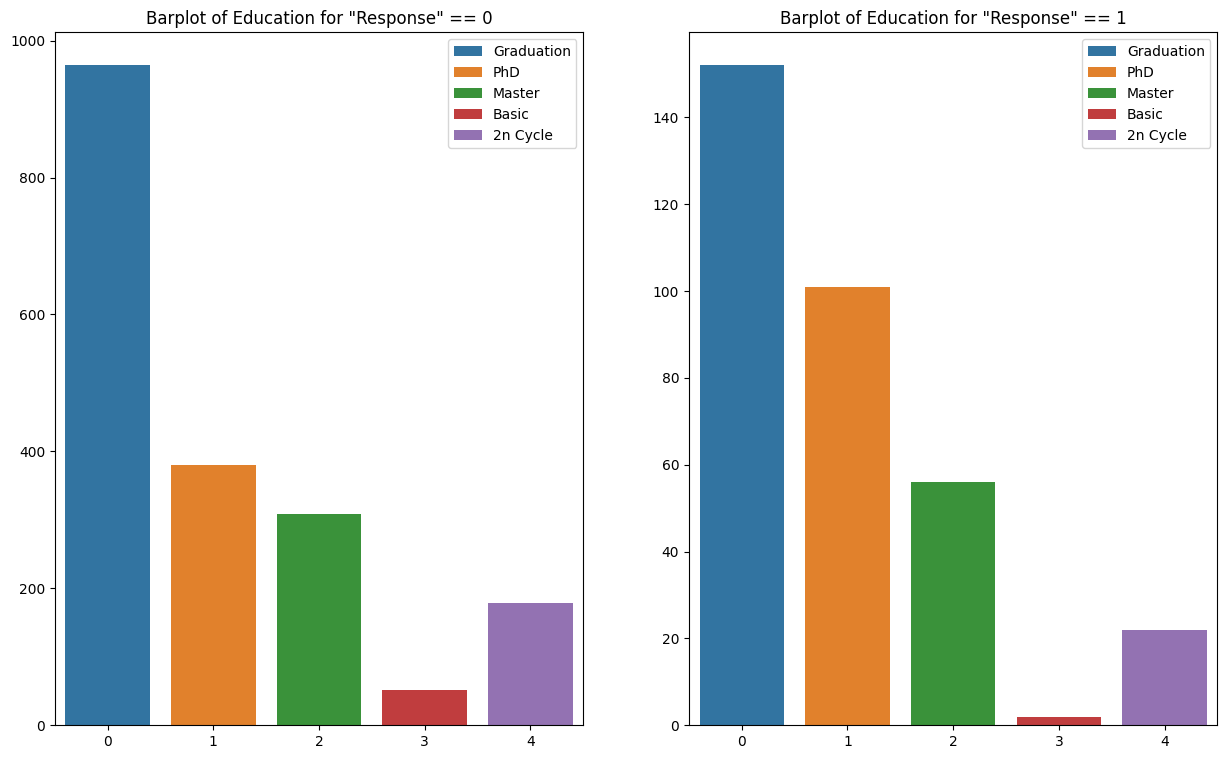

In [351]:
data_column = 'Education'

categories = df[data_column].unique()
category_count = categories.shape[0]
x_vals = np.arange(category_count)

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i in range(2):
    heights = np.zeros(category_count)
    
    for j, category in enumerate(categories):
        heights[j] = df.query('Education==@category and Response==@i').shape[0]
            
    sns.barplot(x=x_vals, y=heights, ax=ax[i], label=categories)
    
    ax[i].set_title(f'Barplot of {data_column} for "Response" == {i}')
    ax[i].legend()

In [516]:
df.groupby('Education').count()['ID']

Education
2n Cycle       200
Basic           54
Graduation    1116
Master         365
PhD            481
Name: ID, dtype: int64

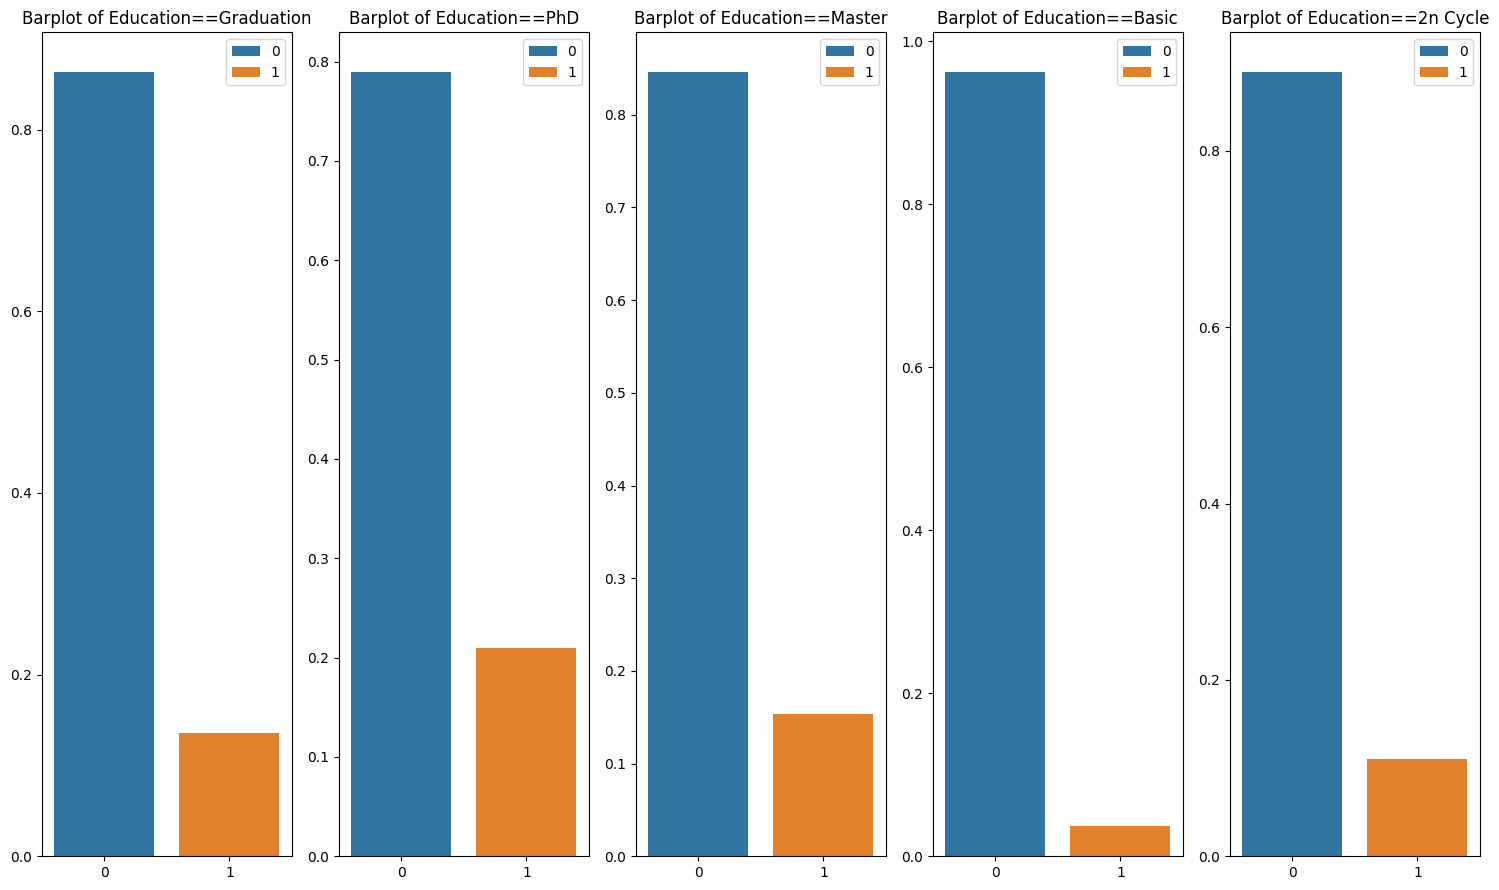

In [366]:
data_column = 'Education'

categories = df[data_column].unique()
category_count = categories.shape[0]
x_vals = [0, 1]

fig, ax = plt.subplots(1, category_count, figsize=(15, 9))

for j, category in enumerate(categories):
    heights = np.zeros(2)
    
    for i in range(2):        
        heights[i] = df.query('Education==@category and Response==@i').shape[0]/df.query('Education==@category').shape[0]        
        
    sns.barplot(x=x_vals, y=heights, ax=ax[j], label=x_vals)
    ax[j].set_title(f'Barplot of {data_column}=={category}')
    ax[j].legend()
    
plt.tight_layout()

### PhD and Masters graduates appear to be be more likely to take up the offer, perhaps this is related to income and no children?

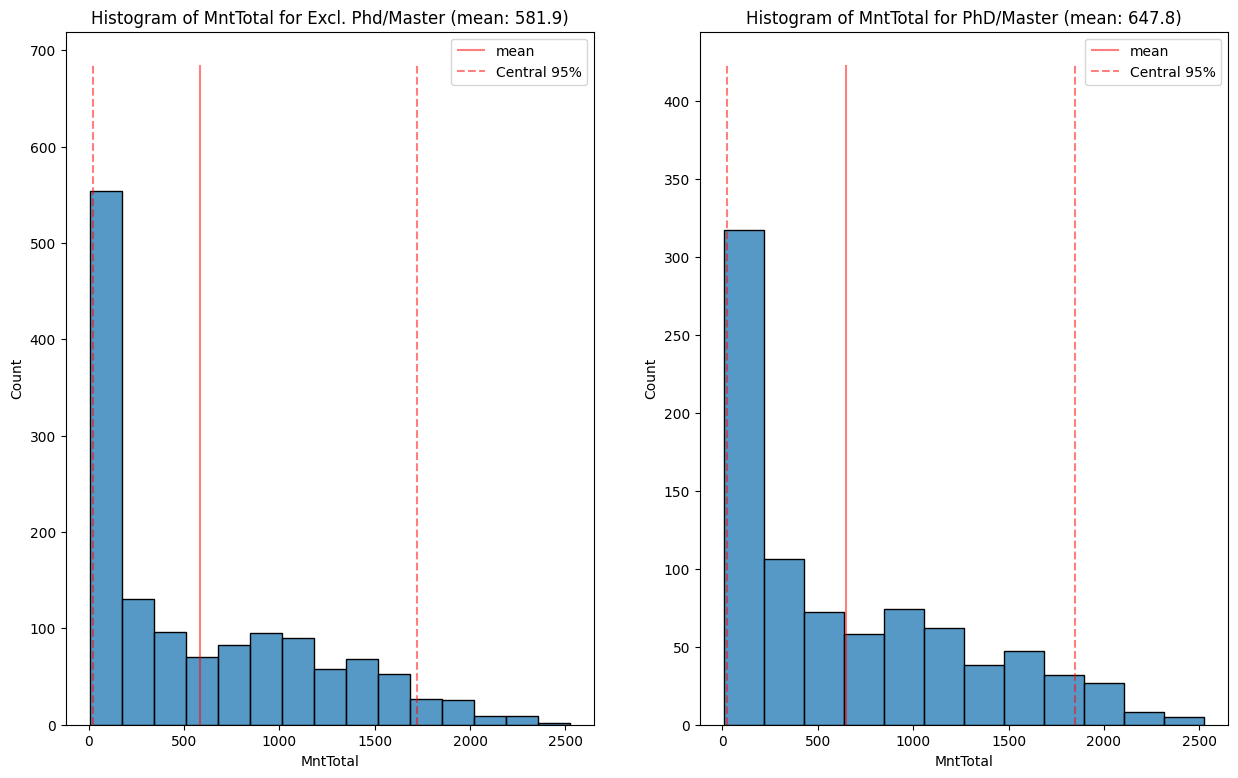

In [381]:
data_column = 'MntTotal'

data_exc_phd_master = df.query('Education not in ("PhD", "Master")')
data_phd_master = df.query('Education in ("PhD", "Master")')

titles = ['Excl. Phd/Master', 'PhD/Master']

dfs = [data_exc_phd_master, data_phd_master]

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i, df_ in enumerate(dfs):
    obs_count = df_.shape[0]
    vertical_line_height = obs_count/2
    
    mean = df_[data_column].mean()
    percentile_5 = df_[data_column].quantile(0.05)
    percentile_95 = df_[data_column].quantile(0.95)
    
    sns.histplot(data=df_, x=data_column, ax=ax[i])
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', alpha=0.5, label='mean')
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', alpha=0.5, label='Central 95%')
    ax[i].set_title(f'Histogram of {data_column} for {titles[i]} (mean: {mean:.1f})')
    ax[i].legend()

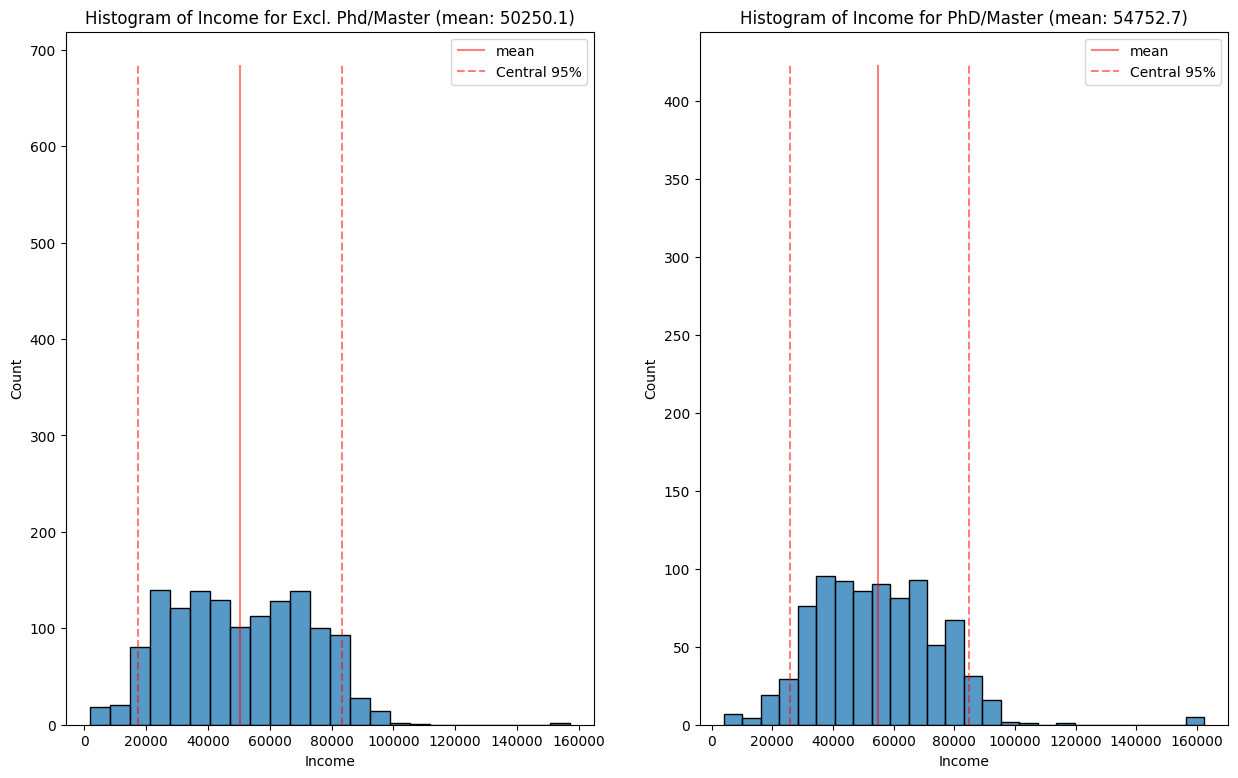

In [383]:
data_column = 'Income'

data_exc_phd_master = df.query('Education not in ("PhD", "Master")')
data_phd_master = df.query('Education in ("PhD", "Master")')

titles = ['Excl. Phd/Master', 'PhD/Master']

dfs = [data_exc_phd_master, data_phd_master]

fig, ax = plt.subplots(1, 2, figsize=(15, 9))

for i, df_ in enumerate(dfs):
    data = df_[df_['Income'] < 300000]
    obs_count = data.shape[0]
    vertical_line_height = obs_count/2
    
    mean = data[data_column].mean()
    percentile_5 = data[data_column].quantile(0.05)
    percentile_95 = data[data_column].quantile(0.95)
    
    sns.histplot(data=data, x=data_column, ax=ax[i])
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', alpha=0.5, label='mean')
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', alpha=0.5, label='Central 95%')
    ax[i].set_title(f'Histogram of {data_column} for {titles[i]} (mean: {mean:.1f})')
    ax[i].legend()

22.239819004524886
37.8377581120944
58.169767441860465
147.14814814814815
291.71627906976744
416.26666666666665
586.1454880294659
686.2402912621359
901.0545851528384
1447.958609271523


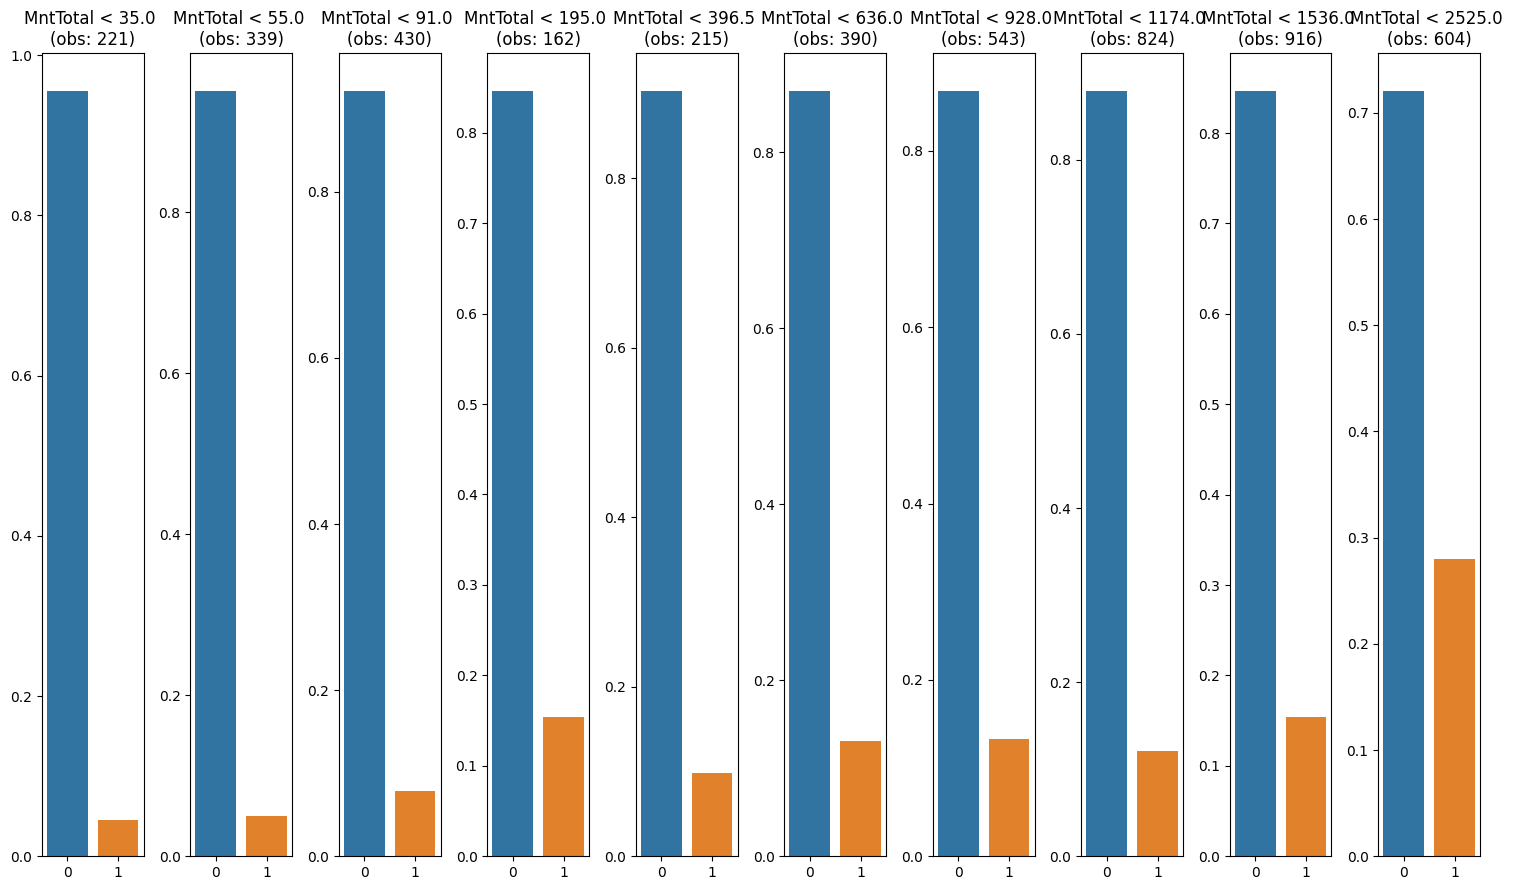

In [767]:
data_column = 'MntTotal'
quantile_count = 10
quantile_bounds_upper = [df[data_column].quantile(i/100) for i in np.linspace(10, 100, 10)]
quantile_bounds_lower = [0] + [(bound - quantile_bounds_upper[i]) for i, bound in enumerate(quantile_bounds_upper[1:])]

fig, ax = plt.subplots(1, quantile_count, figsize=(15, 9))

for i in range(quantile_count):
    data = df.query('MntTotal > @quantile_bounds_lower[@i] and MntTotal < @quantile_bounds_upper[@i]')    
    
    obs_count = data.shape[0]
    
    print(data['MntTotal'].mean())
    
    try:
        height1 = data[data['Response']==0].shape[0]/obs_count
        height2 = data[data['Response']==1].shape[0]/obs_count
        sns.barplot(x=[0, 1], y=[height1, height2], ax=ax[i])
    except ZeroDivisionError:
        pass
    ax[i].set_title(f'{data_column} < {quantile_bounds_upper[i]} \n(obs: {obs_count:.0f})')
    #ax[i].set_ylim(0, 0.3)
    
plt.tight_layout()

### looks like "high spenders" like to take up the offer

In [757]:
# income for the high spend group
data['Income'].mean()

52212.57136404698

In [752]:
quantile_bounds_lower

[0, -2470.0, 56.0, 140.0, 305.5, 441.0, 531.5, 538.0, 608.0, 1351.0]

<AxesSubplot: xlabel='Education'>

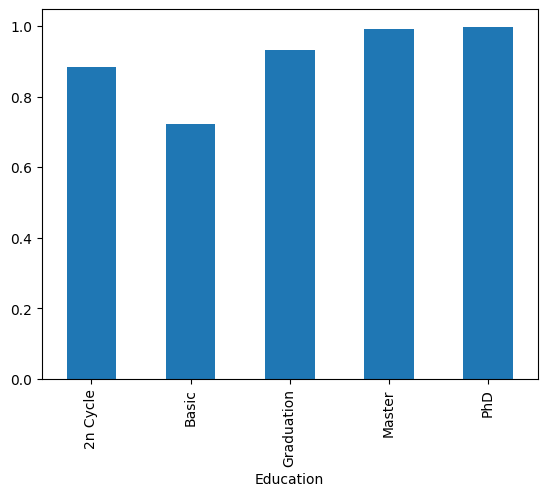

In [398]:
df.groupby('Education')['ChildrenTotal'].mean().plot(kind='bar')

### seems likes PhD and Masters graduates tend to have SLIGHTLY more children so the link to higher instances of taking up the offer is probably linked to income rather than "childlessness"

In [401]:
kid_only = df.query('Kidhome>0 and Teenhome==0')
teen_only = df.query('Kidhome==0 and Teenhome>0')
both_children = df.query('Kidhome>0 and Teenhome>0')
no_children = df.query('Kidhome==0 and Teenhome==0')

dfs = [
    kid_only,
    teen_only,
    both_children,
    no_children    
]

cumsum = 0
for df_ in dfs:
    cumsum += df_.shape[0]
    print(df_.shape[0])
    
# making sure all data is captured
print(cumsum)

514
650
419
633
2216


In [413]:
data[data['Response'] == 1].shape[0]

168

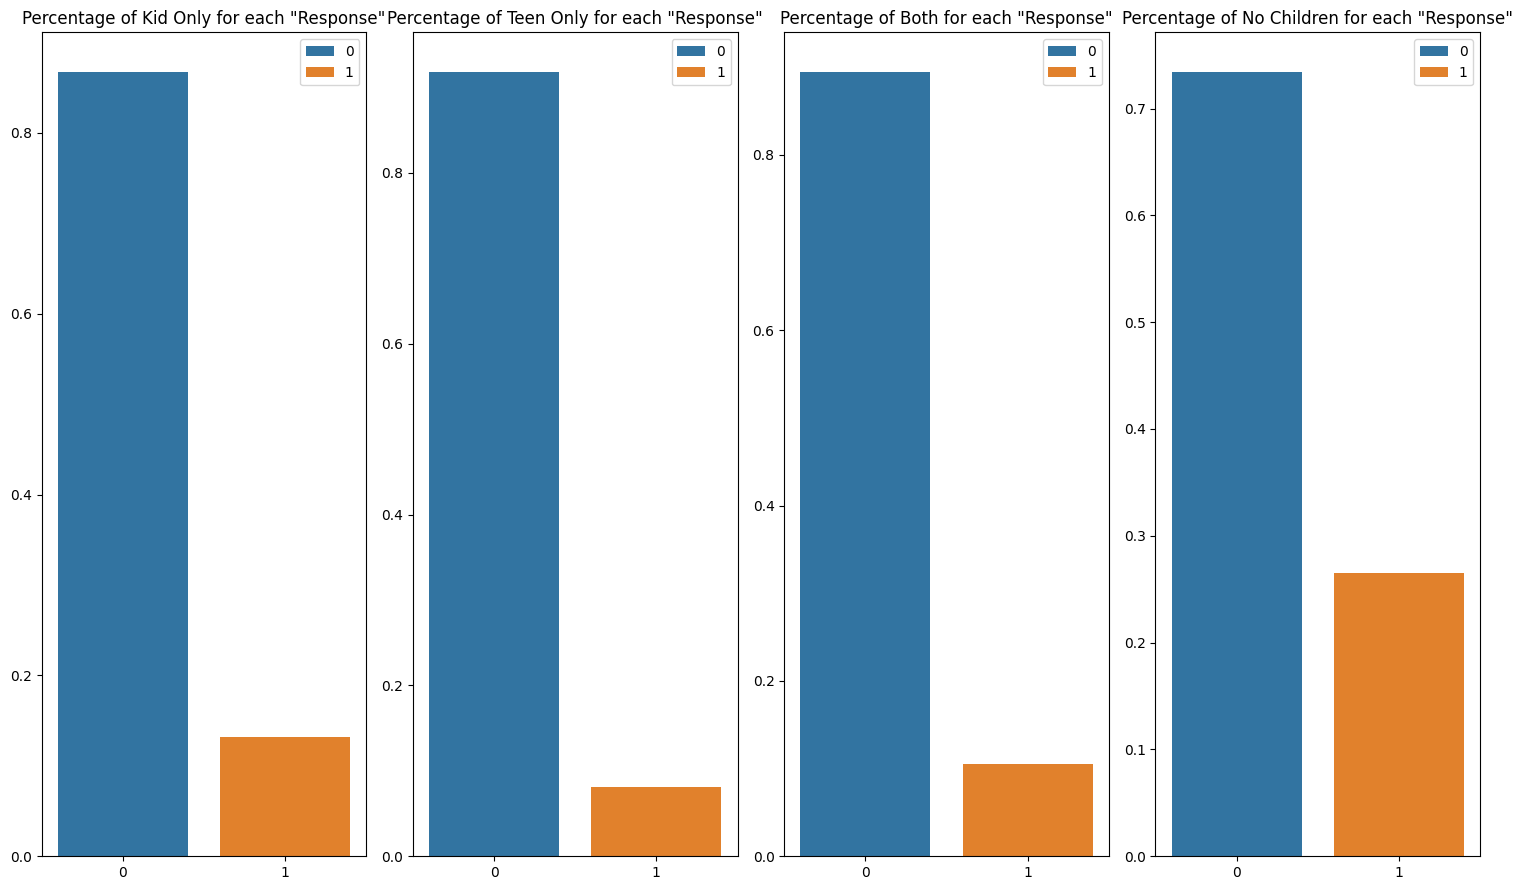

In [517]:
titles = ['Kid Only', 'Teen Only', 'Both', 'No Children']
category_count = len(titles)

responses = [0, 1]

fig, ax = plt.subplots(1, category_count, figsize=(15, 9))

for i, df_ in enumerate(dfs):
    data = df_
    
    obs_count = data.shape[0]
    heights = [data[data['Response'] == j].shape[0]/obs_count for j in responses]    
    
    sns.barplot(x=responses, y=heights, label=responses, ax=ax[i])
    ax[i].set_title(f'Percentage of {titles[i]} for each "Response"')
    ax[i].legend()


plt.tight_layout()

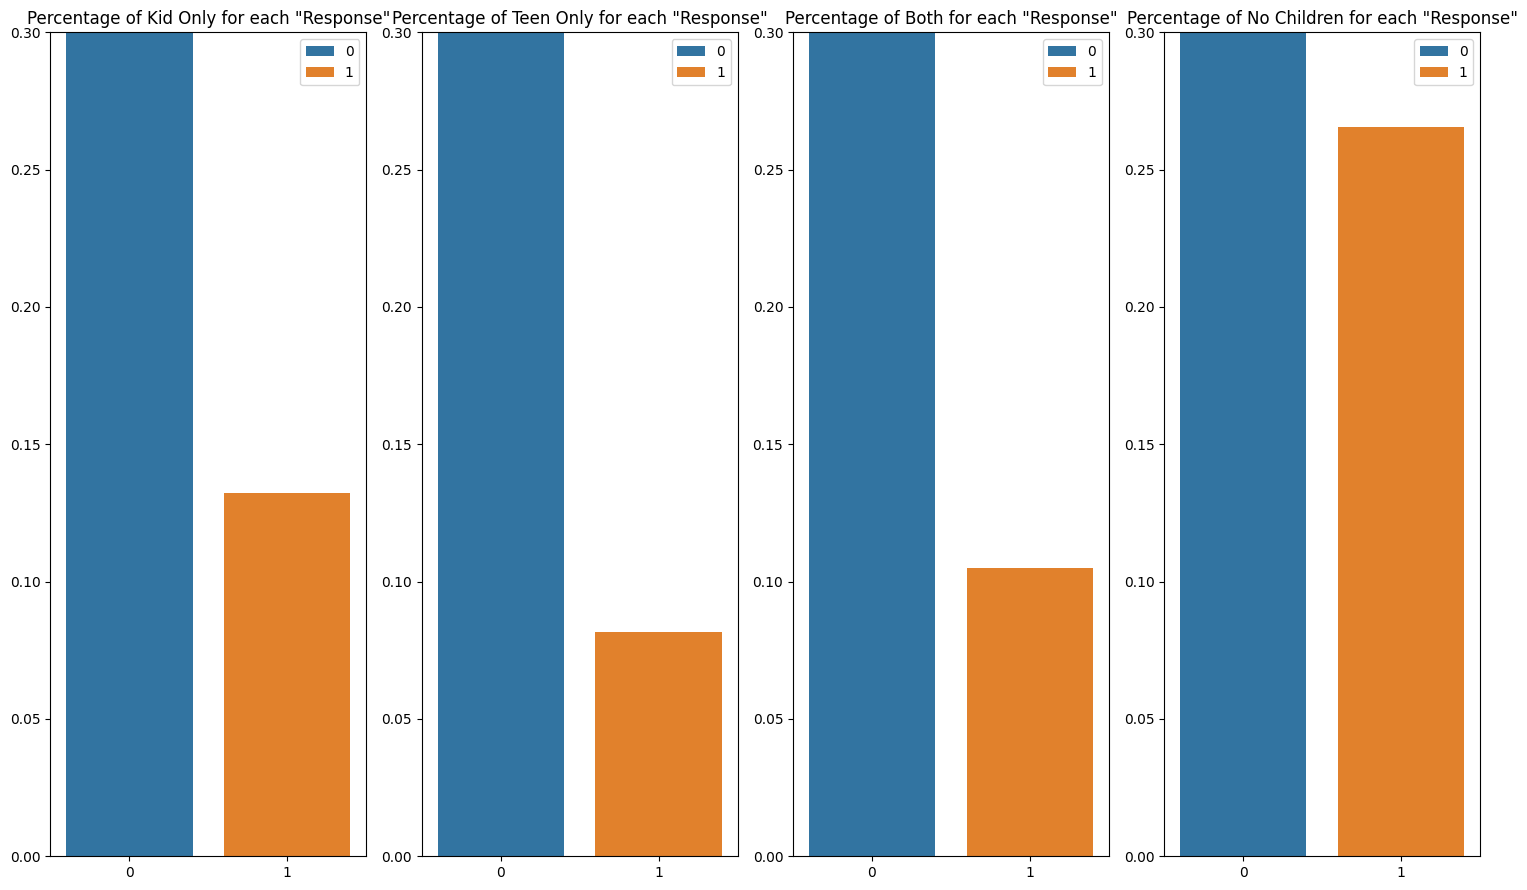

In [518]:
# SAME AS ABOVE just with y axis limited to allow orange bars to stretch
titles = ['Kid Only', 'Teen Only', 'Both', 'No Children']
category_count = len(titles)

responses = [0, 1]

fig, ax = plt.subplots(1, category_count, figsize=(15, 9))

for i, df_ in enumerate(dfs):
    data = df_
    
    obs_count = data.shape[0]
    heights = [data[data['Response'] == j].shape[0]/obs_count for j in responses]    
    
    sns.barplot(x=responses, y=heights, label=responses, ax=ax[i])
    ax[i].set_title(f'Percentage of {titles[i]} for each "Response"')
    ax[i].set_ylim(0, 0.3)
    ax[i].legend()


plt.tight_layout()

## having no children makes a difference, among all parent types it seems that those with "kid" but not "teen" have higher uptake. Maybe they're newer parents and aren't budgeting so tightly yet?
## does age of customer play a role?

Text(0.5, 1.0, 'Histogram of customer ages')

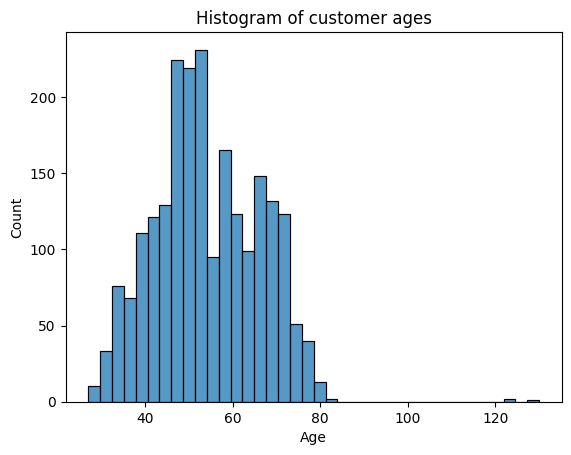

In [430]:
sns.histplot(data=df, x='Age')
plt.title('Histogram of customer ages')

### appears to be some "phantom" customers aver the age of 100

In [433]:
df.groupby('Age')['ID'].count()

Age
27      2
28      5
29      3
30      5
31     13
32     15
33     18
34     29
35     29
36     27
37     41
38     32
39     38
40     41
41     44
42     38
43     39
44     53
45     76
46     52
47     89
48     83
49     69
50     72
51     78
52     86
53     75
54     70
55     51
56     44
57     50
58     74
59     41
60     44
61     44
62     35
63     49
64     50
65     52
66     41
67     55
68     48
69     49
70     35
71     52
72     42
73     29
74     30
75     21
76     16
77     16
78      8
79      7
80      6
82      1
83      1
123     1
124     1
130     1
Name: ID, dtype: int64

In [436]:
# seems like the three oldest customers have made purchases in the last year
# incorrect data, fraud or magic?
df.query('Age>83')['Recency']

192    99
239    23
339    36
Name: Recency, dtype: int64

<AxesSubplot: xlabel='Age', ylabel='MntTotal'>

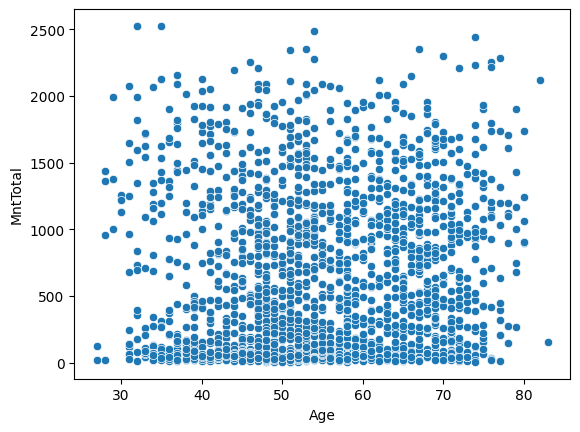

In [437]:
sns.scatterplot(data=df.query('Age<84'), x='Age', y='MntTotal')

### doesn't appear to be a correlation between age and total spend
### how about age and offer uptake?

In [522]:
df.groupby('Response')['Age'].mean()

Response
0    54.298991
1    53.504505
Name: Age, dtype: float64

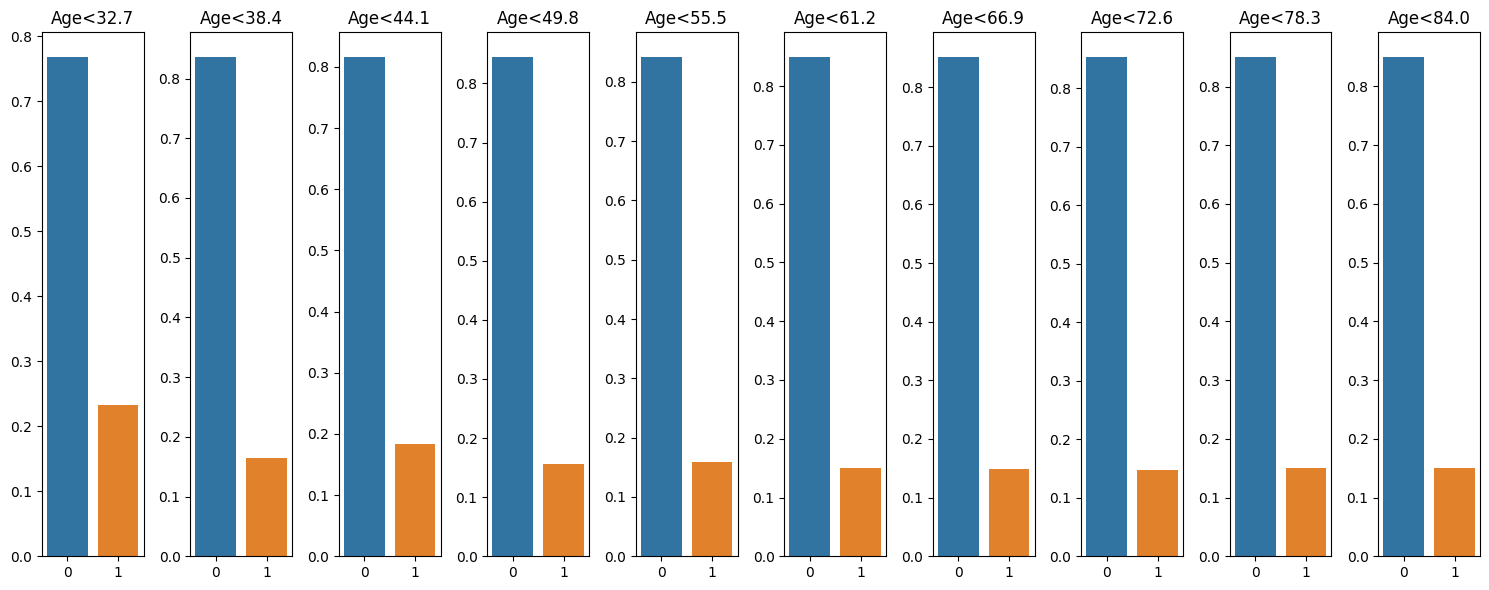

In [459]:
bin_count = 10

min_age = df['Age'].min()
max_age = 84

bin_bounds = np.linspace(min_age, max_age, num=bin_count+1)[1:]

responses = [0, 1]

fig, ax = plt.subplots(1, bin_count, figsize=(15, 6))

for i, bound in enumerate(bin_bounds):
    data = df.query('Age<@bound')
    
    obs_count = data.shape[0]
    heights = [data.query('Response==@j').shape[0]/obs_count for j in responses]
    
    sns.barplot(x=responses, y=heights, ax=ax[i])
    ax[i].set_title(f'Age<{bound:.1f}')
    

plt.tight_layout()

### seems like younger customers are more likely to take up the offer
### let's segment a little further looking at ONLY customers younger than 45, since the "44.1" chart seems to make a cutoff

2
8
18
33
58
68
70
85
77
129


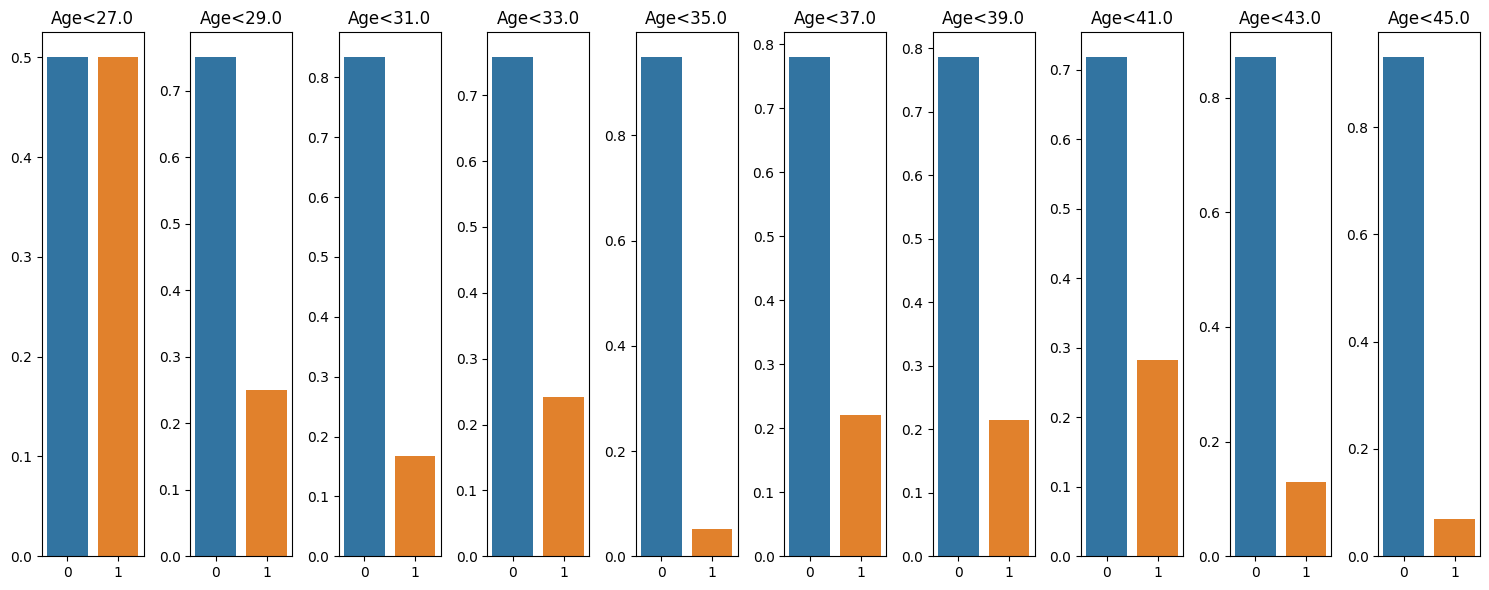

In [815]:
bin_count = 10

min_age = df['Age'].min()
#max_age = df['Age'].max()
max_age = 45

age_bounds_upper = np.linspace(min_age, max_age, num=bin_count)
age_bounds_lower = [0] + [(age_bounds_upper[i]) for i, bound in enumerate(age_bounds_upper[1:])]

responses = [0, 1]

fig, ax = plt.subplots(1, bin_count, figsize=(15, 6))

for i in range(bin_count):
    data = df.query('Age>@age_bounds_lower[@i] and Age<=@age_bounds_upper[@i]')
    
    obs_count = data.shape[0]
    #print(obs_count)
    
    try:
        heights = [data.query('Response==@j').shape[0]/obs_count for j in responses]
        sns.barplot(x=responses, y=heights, ax=ax[i])
        ax[i].set_title(f'Age<{age_bounds_upper[i]:.1f}')
    except ZeroDivisionError:
        pass
    

plt.tight_layout()

<BarContainer object of 10 artists>

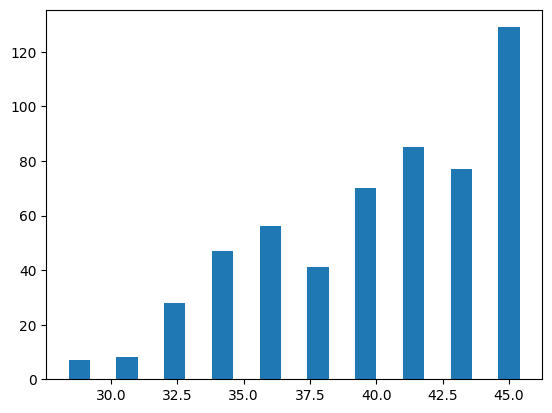

In [506]:
bin_count = 10

min_age = df['Age'].min()
max_age = 45

bin_bounds = np.linspace(min_age, max_age, num=bin_count+1)

obs_counts = [df.query('Age<=@bound').shape[0] for i, bound in enumerate(bin_bounds[1:])]
differences = [0] + obs_counts[:-1]

obs_counts_final = np.zeros(len(obs_counts))
for i, difference in enumerate(differences):
    obs_counts_final[i] = obs_counts[i] - differences[i]
    

plt.bar(x=bin_bounds[1:], height=obs_counts_final)

### only 21 people made complaints not likely going be be a huge driver of offer uptake

In [510]:
df['Complain'].sum()

21

# 3) modelling
## we'll try some classification models and also an ensemble of models to see what fits the data best
## we'll 10-Fold Cross-Validation to judge the models' "out-of-sample" performance in order to prevent overfitting and compare them to eachother and the ensemble

## 3a) Selecting and transforming data
### based on the exploratory analysis above we'll choose/create the following variables
- Education
  - Phd, Master and Less than master
- Marital Status   
  - Single, Divorced, Other
- Income
  - we'll start with a continuous income variable
- Children
  - No children, Kid only, Other
- Customer Years
  - Start with a continuous variable for years of custom
- Recency
  - Start with a continuous variable for purchase recency
- Total spend
  - Dummy variable == 1 if the customer is in the top 10% of spenders, 0 otherwise
- AcceptedTotal
  - Binary variable for whether or not the customer has previously accepted an offer

In [549]:
model_df = df.copy()
model_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Z_CostContact,Z_Revenue,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,3,11,1,0,1617,25,0,0.098630,66
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,3,11,0,2,27,6,0,1.605479,69
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,3,11,0,0,776,21,0,1.060274,58
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,3,11,0,1,53,8,0,1.534247,39
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,3,11,0,1,422,19,0,1.473973,42


In [550]:
drop_cols = [
    'ID',
    'Year_Birth',
    #'Kidhome',
    'Teenhome',
    'Dt_Customer',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Z_CostContact',
    'Z_Revenue'
]

model_df.drop(drop_cols, axis=1, inplace=True)
model_df.head()

,Education,Marital_Status,Income,Kidhome,Recency,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age
0,Graduation,Single,58138.0,0,58,1,0,1617,25,0,0.098630,66
1,Graduation,Single,46344.0,1,38,0,2,27,6,0,1.605479,69
2,Graduation,Together,71613.0,0,26,0,0,776,21,0,1.060274,58
3,Graduation,Together,26646.0,1,26,0,1,53,8,0,1.534247,39
4,PhD,Married,58293.0,1,94,0,1,422,19,0,1.473973,42


In [551]:
# create columns for PhD, Masters and Other
model_df['EducPhD'] = np.where(model_df['Education']=='PhD', 1, 0)
model_df['EducMaster'] = np.where(model_df['Education']=='Master', 1, 0)
model_df['EducLessThanMaster'] = np.where(model_df['Education']!='Master', np.where(model_df['Education']!='PhD',1,0), 0)

In [552]:
model_df.groupby('Education')['EducPhD'].sum()

Education
2n Cycle        0
Basic           0
Graduation      0
Master          0
PhD           481
Name: EducPhD, dtype: int32

In [553]:
model_df.groupby('Education')['EducMaster'].sum()

Education
2n Cycle        0
Basic           0
Graduation      0
Master        365
PhD             0
Name: EducMaster, dtype: int32

In [554]:
model_df.groupby('Education')['EducLessThanMaster'].sum()

Education
2n Cycle       200
Basic           54
Graduation    1116
Master           0
PhD              0
Name: EducLessThanMaster, dtype: int32

In [572]:
# create columns for No chilren, kid only and other
model_df['ChildrenNone'] = np.where(model_df['ChildrenTotal']==0, 1, 0)
model_df['ChildrenKid'] = np.where((model_df['ChildrenTotal'] == model_df['Kidhome']) & (model_df['Kidhome']>0), 1, 0)
model_df['ChildrenOther'] = np.where((model_df['ChildrenTotal']>0) & (model_df['Kidhome']==0), 1, 0)

In [573]:
model_df.groupby('ChildrenTotal')[['ChildrenNone','ChildrenKid','ChildrenOther']].sum()

,ChildrenNone,ChildrenKid,ChildrenOther
ChildrenTotal,,,
0,633,0,0
1,0,497,620
2,0,17,30
3,0,0,0


In [592]:
model_df.query('ChildrenTotal>0').groupby('Kidhome')[['ChildrenNone','ChildrenKid','ChildrenOther']].sum()

,ChildrenNone,ChildrenKid,ChildrenOther
Kidhome,,,
0,0,0,650
1,0,497,0
2,0,17,0


In [586]:
model_df.query('ChildrenTotal>2 and Kidhome==0')

,Education,Marital_Status,Income,Kidhome,Recency,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age,EducPhD,EducMaster,EducLessThanMaster,ChildrenNone,ChildrenKid,ChildrenOther


In [595]:
# create marital status variables
model_df['MaritalSingle'] = np.where(model_df['Marital_Status']=='Single', 1, 0)
model_df['MaritalDivorced'] = np.where(model_df['Marital_Status']=='Divorced', 1, 0)
model_df['MaritalOther'] = np.where((model_df['Marital_Status']!='Single') & (model_df['Marital_Status']!='Divorced'), 1, 0)

model_df.head()

,Education,Marital_Status,Income,Kidhome,Recency,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,...,Age,EducPhD,EducMaster,EducLessThanMaster,ChildrenNone,ChildrenKid,ChildrenOther,MaritalSingle,MaritalDivorced,MaritalOther
0,Graduation,Single,58138.0,0,58,1,0,1617,25,0,...,66,0,0,1,1,0,0,1,0,0
1,Graduation,Single,46344.0,1,38,0,2,27,6,0,...,69,0,0,1,0,0,0,1,0,0
2,Graduation,Together,71613.0,0,26,0,0,776,21,0,...,58,0,0,1,1,0,0,0,0,1
3,Graduation,Together,26646.0,1,26,0,1,53,8,0,...,39,0,0,1,0,1,0,0,0,1
4,PhD,Married,58293.0,1,94,0,1,422,19,0,...,42,1,0,0,0,1,0,0,0,1


In [596]:
model_df.groupby('Marital_Status')[['MaritalSingle', 'MaritalDivorced', 'MaritalOther']].sum()

,MaritalSingle,MaritalDivorced,MaritalOther
Marital_Status,,,
Absurd,0,0,2
Alone,0,0,3
Divorced,0,232,0
Married,0,0,857
Single,471,0,0
Together,0,0,573
Widow,0,0,76
YOLO,0,0,2


In [773]:
# add a column for to 10% of spenders
threshold_spend = model_df['MntTotal'].quantile(0.9)
model_df['HighSpend'] = np.where(model_df['MntTotal']>threshold_spend, 1, 0)
model_df.head()

,Education,Marital_Status,Income,Kidhome,Recency,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,...,EducPhD,EducMaster,EducLessThanMaster,ChildrenNone,ChildrenKid,ChildrenOther,MaritalSingle,MaritalDivorced,MaritalOther,HighSpend
0,Graduation,Single,58138.0,0,58,1,0,1617,25,0,...,0,0,1,1,0,0,1,0,0,1
1,Graduation,Single,46344.0,1,38,0,2,27,6,0,...,0,0,1,0,0,0,1,0,0,0
2,Graduation,Together,71613.0,0,26,0,0,776,21,0,...,0,0,1,1,0,0,0,0,1,0
3,Graduation,Together,26646.0,1,26,0,1,53,8,0,...,0,0,1,0,1,0,0,0,1,0
4,PhD,Married,58293.0,1,94,0,1,422,19,0,...,1,0,0,0,1,0,0,0,1,0


In [819]:
model_df.groupby('HighSpend')['MntTotal'].mean()

HighSpend
0     471.631078
1    1829.751131
Name: MntTotal, dtype: float64

In [838]:
model_df.groupby('HighSpend')['AcceptedTotal'].mean()

HighSpend
0    0.208020
1    1.113122
Name: AcceptedTotal, dtype: float64

In [536]:
# add a column for accepting ANY previous offer
model_df['AcceptedPrevious'] = np.where(model_df['AcceptedPrevious']>0, 1, 0)
model_df.head()

,Education,Marital_Status,Income,Recency,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age,AcceptedPrevious
0,Graduation,Single,58138.0,58,1,0,1617,25,0,0.098630,66,0
1,Graduation,Single,46344.0,38,0,2,27,6,0,1.605479,69,0
2,Graduation,Together,71613.0,26,0,0,776,21,0,1.060274,58,0
3,Graduation,Together,26646.0,26,0,1,53,8,0,1.534247,39,0
4,PhD,Married,58293.0,94,0,1,422,19,0,1.473973,42,0


In [543]:
# check it worked
model_df.groupby('AcceptedTotal')['AcceptedPrevious'].agg(['count', 'sum'])

,count,sum
AcceptedTotal,,
0,1757,0
1,323,323
2,81,81
3,44,44
4,11,11


In [777]:
#model_df.info()
for col in model_df.columns:
    print(col)

Education
Marital_Status
Income
Kidhome
Recency
Response
ChildrenTotal
MntTotal
NumPurchasesTotal
AcceptedTotal
CustomerYears
Age
EducPhD
EducMaster
EducLessThanMaster
ChildrenNone
ChildrenKid
ChildrenOther
MaritalSingle
MaritalDivorced
MaritalOther
HighSpend


In [1065]:
model_data_columns = [
    #'Income',
    'Recency',
    #'MntTotal',
    'AcceptedTotal',
    'EducPhD',
    'EducMaster',
    #'EducLessThanMaster',
    #'Age',
    'ChildrenNone',
    'ChildrenKid',
    #'ChildrenOther',
    'MaritalSingle',
    'MaritalDivorced',
    #'MaritalOther',
    'CustomerYears',
    #'HighSpend',
]

### correlation matrix of included variables

In [1066]:
model_df[model_data_columns].corr()

,Recency,AcceptedTotal,EducPhD,EducMaster,ChildrenNone,ChildrenKid,MaritalSingle,MaritalDivorced,CustomerYears
Recency,1.000000,-0.013647,-0.008248,-0.026004,-0.002485,0.002050,0.003356,0.005606,-0.025963
AcceptedTotal,-0.013647,1.000000,0.033087,-0.012316,0.279788,-0.134331,-0.007297,-0.002609,0.012009
EducPhD,-0.008248,0.033087,1.000000,-0.233812,-0.010657,-0.087058,-0.016681,0.005873,0.035106
EducMaster,-0.026004,-0.012316,-0.233812,1.000000,-0.011479,-0.016319,-0.007669,-0.004820,0.032492
ChildrenNone,-0.002485,0.279788,-0.010657,-0.011479,1.000000,-0.347507,0.076818,-0.026987,0.000888
ChildrenKid,0.002050,-0.134331,-0.087058,-0.016319,-0.347507,1.000000,0.041165,-0.037758,0.023851
MaritalSingle,0.003356,-0.007297,-0.016681,-0.007669,0.076818,0.041165,1.000000,-0.177658,-0.000602
MaritalDivorced,0.005606,-0.002609,0.005873,-0.004820,-0.026987,-0.037758,-0.177658,1.000000,-0.007888
CustomerYears,-0.025963,0.012009,0.035106,0.032492,0.000888,0.023851,-0.000602,-0.007888,1.000000


In [1067]:
# names to be used by statsmodels summary
coefficient_names = ['constant'] + model_data_columns
coefficient_names

['constant',
 'Recency',
 'AcceptedTotal',
 'EducPhD',
 'EducMaster',
 'ChildrenNone',
 'ChildrenKid',
 'MaritalSingle',
 'MaritalDivorced',
 'CustomerYears']

In [1068]:
X = model_df[model_data_columns].values
y = model_df['Response'].values

In [1069]:
# train test split
# setting random state so that all models see the SAME training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [1070]:
# fit the scaler ONLY to the training data
x_scaler = StandardScaler().fit(x_train)


# transform trainign and test data using the scaler
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

## 3b) Random Forest Classifier

In [1071]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(x_train_scaled, y_train)

preds_rf_train = model_rf.predict(x_train_scaled)

print(confusion_matrix(y_train, preds_rf_train))
print(classification_report(y_train, preds_rf_train))

[[1265    1]
 [   8  210]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1266
           1       1.00      0.96      0.98       218

    accuracy                           0.99      1484
   macro avg       0.99      0.98      0.99      1484
weighted avg       0.99      0.99      0.99      1484



In [1072]:
preds_rf_test = model_rf.predict(x_test_scaled)

print(confusion_matrix(y_test, preds_rf_test))
print(classification_report(y_test, preds_rf_test))

[[588  29]
 [ 64  51]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       617
           1       0.64      0.44      0.52       115

    accuracy                           0.87       732
   macro avg       0.77      0.70      0.72       732
weighted avg       0.86      0.87      0.86       732



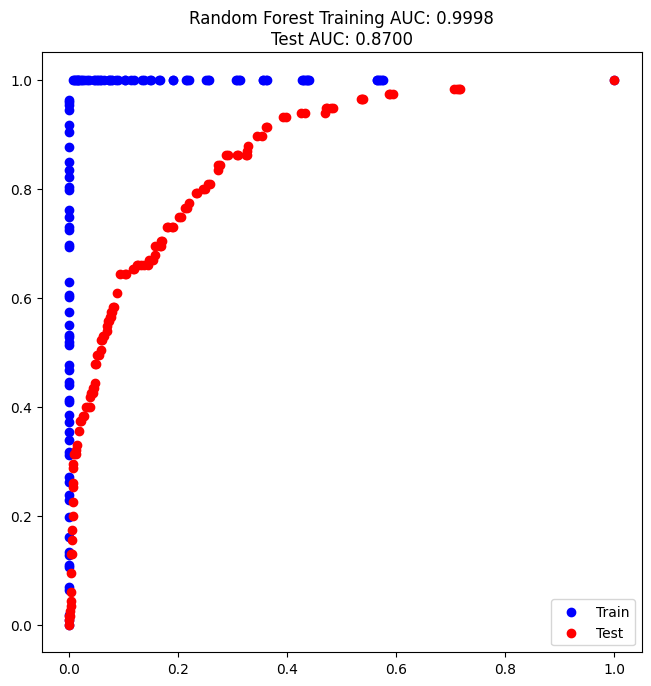

"fig, ax = plt.subplots(1, 2, figsize=(15, 9))\n\nroc_rf_train = roc_curve(y_train, preds_rf_train_prob)\nroc_auc_rf_train = roc_auc_score(y_train, preds_rf_train_prob)\n\nroc_rf_test = roc_curve(y_test, preds_rf_test_prob)\nroc_auc_rf_test = roc_auc_score(y_test, preds_rf_test_prob)\n\nmeasures = ['False Positive Rates', 'True Positive Rates']\n\nfor i in range(2):\n    ax[i].plot(roc_rf_train[i], label='Train')\n    ax[i].plot(roc_rf_test[i], label='Test')\n    ax[i].set_title(f'{measures[i]}\n')\n    ax[i].legend()"

In [1130]:
preds_rf_train_prob = model_rf.predict_proba(x_train_scaled)[:, 1]
preds_rf_test_prob = model_rf.predict_proba(x_test_scaled)[:, 1]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])

ax.scatter(x=roc_rf_train[0], y=roc_rf_train[1], label='Train', color='blue')
ax.scatter(x=roc_rf_test[0], y=roc_rf_test[1], label='Test', color='red')
ax.set_title(f'Random Forest Training AUC: {roc_auc_rf_train:.4f}\nTest AUC: {roc_auc_rf_test:.4f}', fontsize=12)
ax.legend()
plt.show()

## 3c) Logistic Regression
### although the logistic does not fit as well as the Random Forest, it does give us INTERPRETABLE coefficients as well as p-values for the coefficients to aid in model selection

In [1073]:
model_lr = Logit(y_train, add_constant(x_train_scaled)).fit()
model_lr.summary(xname=coefficient_names)

Optimization terminated successfully.
         Current function value: 0.283208
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1484
Model:                          Logit   Df Residuals:                     1474
Method:                           MLE   Df Model:                            9
Date:                Tue, 28 Mar 2023   Pseudo R-squ.:                  0.3213
Time:                        05:25:07   Log-Likelihood:                -420.28
converged:                       True   LL-Null:                       -619.26
Covariance Type:            nonrobust   LLR p-value:                 3.716e-80
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant           -2.5211      0.122    -20.685      0.000      -2.760      -2.282
Recency            -0.8777      0.100     -8.750      0.000      -1.074      -0.681
AcceptedTotal       1.0174      0.085     11.954      0.000       0.851       1.184
EducPhD             0.3792      0.087      4.340      0.000       0.208       0.550
EducMaster          0.1495      0.091      1.637      0.102      -0.029       0.328
ChildrenNone        0.4311      0.096      4.485      0.000       0.243       0.619
ChildrenKid         0.2353      0.104      2.264      0.024       0.032       0.439
MaritalSingle       0.4303      0.085      5.060      0.000       0.264       0.597
MaritalDivorced     0.3672      0.082      4.482      0.000       0.207       0.528
CustomerYears      -0.7325      0.096     -7.648      0.000      -0.920      -0.545
===================================================================================
"""

In [1074]:
preds_lr_train = model_lr.predict(add_constant(x_train_scaled))

preds_lr_train = np.where(preds_lr_train>0.5, 1, 0)

print(confusion_matrix(y_train, preds_lr_train))
print(classification_report(y_train, preds_lr_train))

[[1237   29]
 [ 131   87]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1266
           1       0.75      0.40      0.52       218

    accuracy                           0.89      1484
   macro avg       0.83      0.69      0.73      1484
weighted avg       0.88      0.89      0.88      1484



In [1075]:
preds_lr_test = model_lr.predict(add_constant(x_test_scaled))

preds_lr_test = np.where(preds_lr_test>0.5, 1, 0)

print(confusion_matrix(y_test, preds_lr_test))
print(classification_report(y_test, preds_lr_test))

[[605  12]
 [ 65  50]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       617
           1       0.81      0.43      0.56       115

    accuracy                           0.89       732
   macro avg       0.85      0.71      0.75       732
weighted avg       0.89      0.89      0.88       732



In [1159]:
df['Response'].mean()

0.15027075812274368

In [1076]:
# using unscaled data to make coefficients easier to interpret
model_lr2 = Logit(y_train, add_constant(x_train)).fit()
model_lr2.summary(xname=coefficient_names)

Optimization terminated successfully.
         Current function value: 0.283208
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1484
Model:                          Logit   Df Residuals:                     1474
Method:                           MLE   Df Model:                            9
Date:                Tue, 28 Mar 2023   Pseudo R-squ.:                  0.3213
Time:                        05:25:14   Log-Likelihood:                -420.28
converged:                       True   LL-Null:                       -619.26
Covariance Type:            nonrobust   LLR p-value:                 3.716e-80
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
constant           -1.2280      0.254     -4.829      0.000      -1.726      -0.730
Recency            -0.0303      0.003     -8.750      0.000      -0.037      -0.024
AcceptedTotal       1.4914      0.125     11.954      0.000       1.247       1.736
EducPhD             0.9306      0.214      4.340      0.000       0.510       1.351
EducMaster          0.4053      0.248      1.637      0.102      -0.080       0.890
ChildrenNone        0.9414      0.210      4.485      0.000       0.530       1.353
ChildrenKid         0.5594      0.247      2.264      0.024       0.075       1.044
MaritalSingle       1.0572      0.209      5.060      0.000       0.648       1.467
MaritalDivorced     1.2145      0.271      4.482      0.000       0.683       1.746
CustomerYears      -1.3242      0.173     -7.648      0.000      -1.664      -0.985
===================================================================================
"""

In [1077]:
preds_lr2_train = model_lr2.predict(add_constant(x_train))

preds_lr2_train_binary = np.where(preds_lr2_train>0.5, 1, 0)

print(confusion_matrix(y_train, preds_lr2_train_binary))
print(classification_report(y_train, preds_lr2_train_binary))

[[1237   29]
 [ 131   87]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1266
           1       0.75      0.40      0.52       218

    accuracy                           0.89      1484
   macro avg       0.83      0.69      0.73      1484
weighted avg       0.88      0.89      0.88      1484



In [1078]:
preds_lr2_test = model_lr2.predict(add_constant(x_test))

preds_lr2_test_binary = np.where(preds_lr2_test>0.5, 1, 0)

print(confusion_matrix(y_test, preds_lr2_test_binary))
print(classification_report(y_test, preds_lr2_test_binary))

[[605  12]
 [ 65  50]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       617
           1       0.81      0.43      0.56       115

    accuracy                           0.89       732
   macro avg       0.85      0.71      0.75       732
weighted avg       0.89      0.89      0.88       732



In [1079]:
np.array([preds_lr2_test, y_test]).shape

(2, 732)

In [1080]:
avp_lr_test_df = pd.DataFrame(np.concatenate([y_test.reshape(-1, 1), preds_lr2_test.reshape(-1, 1)], axis=1), columns=['Actual', 'Predicted']).sort_values(by='Predicted')
avp_lr_test_df['id'] = np.arange(0, avp_lr_test_df.shape[0])

avp_lr_test_df.head()

,Actual,Predicted,id
596,0.0,0.001163,0
260,0.0,0.001246,1
183,0.0,0.001635,2
306,0.0,0.001706,3
44,0.0,0.002443,4


<AxesSubplot: xlabel='id', ylabel='Predicted'>

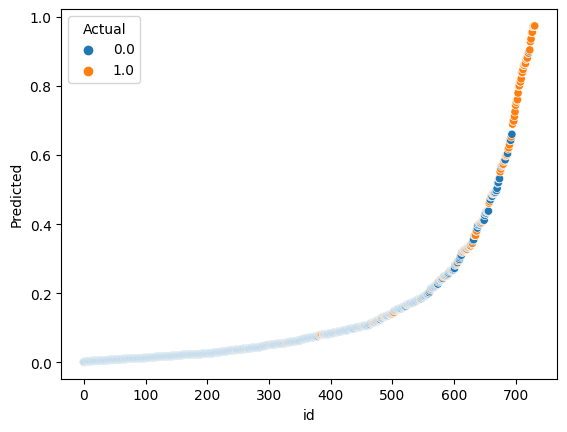

In [1081]:
sns.scatterplot(data=avp_lr_test_df.sort_values(by='Predicted'), x='id', y='Predicted', hue='Actual')

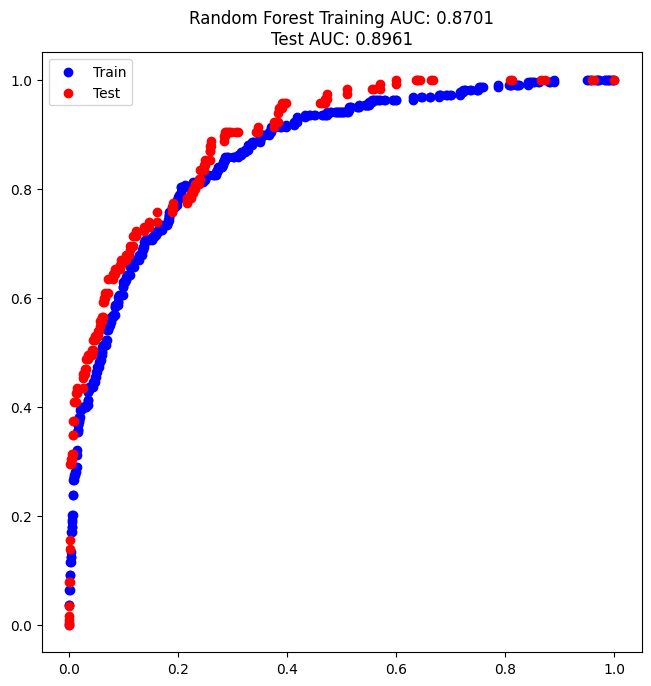

In [1134]:
preds_lr2_train_prob = model_lr2.predict(add_constant(x_train))
preds_lr2_test_prob = model_lr2.predict(add_constant(x_train))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])

ax.scatter(x=roc_lr2_train[0], y=roc_lr2_train[1], label='Train', color='blue')
ax.scatter(x=roc_lr2_test[0], y=roc_lr2_test[1], label='Test', color='red')
ax.set_title(f'Random Forest Training AUC: {roc_auc_lr2_train:.4f}\nTest AUC: {roc_auc_lr2_test:.4f}', fontsize=12)
ax.legend()
plt.show()

# 4) frequency, recency, value study
### rank customers by Num_Purchases, Recency and TotalSpend to segment them
### be sure to check for high value customers who have not made recent purchases, they may be considering taking their custom elsewhere

In [978]:
df['RankValue'] = (6**df['MntTotal'].rank(pct=True)).apply(lambda x: int(x))
df['RankFrequency'] = (6**df['NumPurchasesTotal'].rank(pct=True)).apply(lambda x: int(x))
df['RankRecency'] = (6**df['Recency'].rank(pct=True)).apply(lambda x: int(x))

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age,RankValue,RankFrequency,RankRecency
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1,0,1617,25,0,0.098630,66,5,4,2
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,2,27,6,0,1.605479,69,1,1,2
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,776,21,0,1.060274,58,3,3,1
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,1,53,8,0,1.534247,39,1,1,1
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,1,422,19,0,1.473973,42,2,3,5


In [981]:
df['AvgRFM'] = (df['RankValue'] + df['RankFrequency'] + df['RankRecency'])/3
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,ChildrenTotal,MntTotal,NumPurchasesTotal,AcceptedTotal,CustomerYears,Age,RankValue,RankFrequency,RankRecency,AvgRFM
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,1617,25,0,0.098630,66,5,4,2,3.666667
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,2,27,6,0,1.605479,69,1,1,2,1.333333
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,776,21,0,1.060274,58,3,3,1,2.333333
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,1,53,8,0,1.534247,39,1,1,1,1.000000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,1,422,19,0,1.473973,42,2,3,5,3.333333


Text(0.5, 1.0, 'Histogram for "RankValue">3 \n (mean: 50.2)')

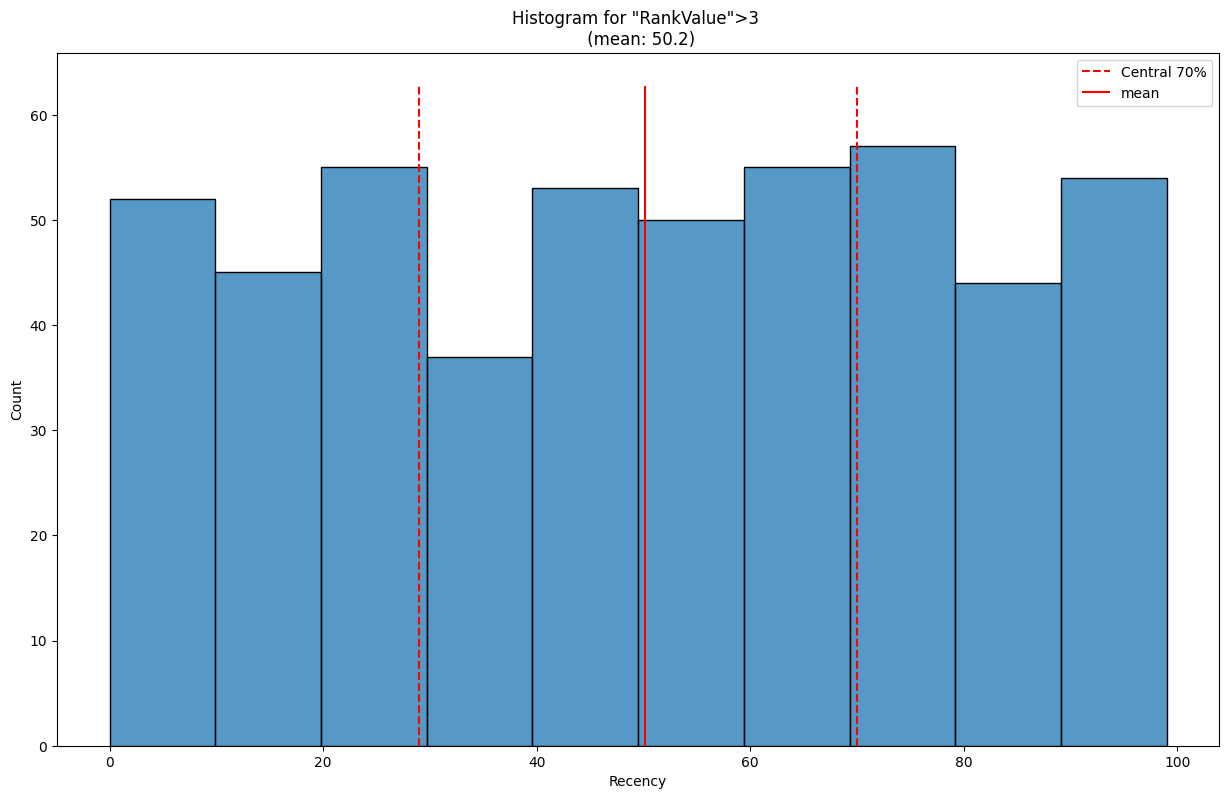

In [1020]:
data = df.query('RankValue>3')

percentile = 30
diff = 100 - percentile

obs_count = data.shape[0]
vertical_line_height = obs_count/8

mean = data[data_column].mean()
percentile_5 = data[data_column].quantile(percentile/100)
percentile_95 = data[data_column].quantile(1-(percentile/100))

fig, ax = plt.subplots(1, 1, figsize=(15, 9))

sns.histplot(data=data, x='Recency', ax=ax)
ax.vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', label=f'Central {diff}%')
ax.vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', label='mean')
ax.legend()
ax.set_title(f'Histogram for "RankValue">3 \n (mean: {mean:.1f})')

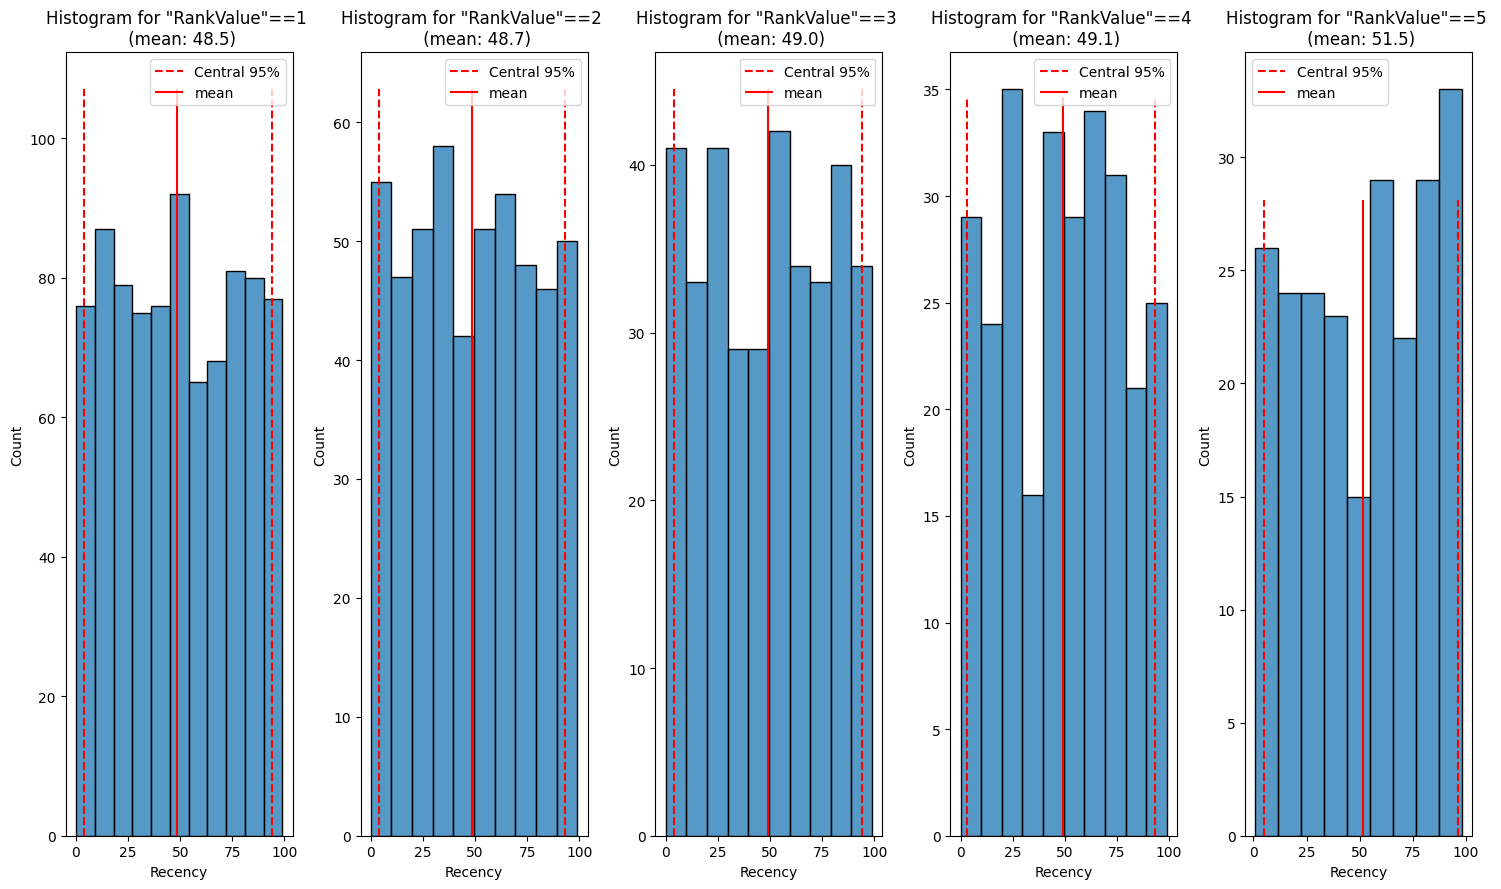

In [1017]:
data_column = 'Recency'
fig, ax = plt.subplots(1, 5, figsize=(15, 9))

for i in range(5):
    data = df.query('RankValue==@i+1')
    
    obs_count = data.shape[0]
    vertical_line_height = obs_count/8
    
    mean = data[data_column].mean()
    percentile_5 = data[data_column].quantile(0.05)
    percentile_95 = data[data_column].quantile(0.95)
    
    sns.histplot(data=data, x='Recency', ax=ax[i])
    ax[i].vlines(x=[percentile_5, percentile_95], ymin=0, ymax=vertical_line_height, color='red', linestyle='--', label='Central 95%')
    ax[i].vlines(x=mean, ymin=0, ymax=vertical_line_height, color='red', label='mean')
    ax[i].legend()
    ax[i].set_title(f'Histogram for "RankValue"=={i+1} \n (mean: {mean:.1f})')
    
plt.tight_layout()

### higher value customers tend to have higher recency (i.e. made last purchase longer ago)
### maybe when deciding to send out promotional material for upcoming sales, we bother these people less. the idea is that they are already aware of the company and don't need to be contacted as frequently. this can be argued both ways